

```
# Dataset Source:
https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset

# Github Project Address:
https://github.com/MachineLearningOrganizaion/ml-in-practice
```



In [ ]:

from google.colab import files
uploaded = files.upload()

print('Data source import complete.')

Saving heart_disease_health_indicators_BRFSS2015.csv to heart_disease_health_indicators_BRFSS2015 (1).csv
Data source import complete.


# Heart Diseases Project
## using multimodels for classification(binary classification) and also used neural networks

## import needed libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
import xgboost as xgb
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Input


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

## Exploring the data

In [ ]:
data=pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


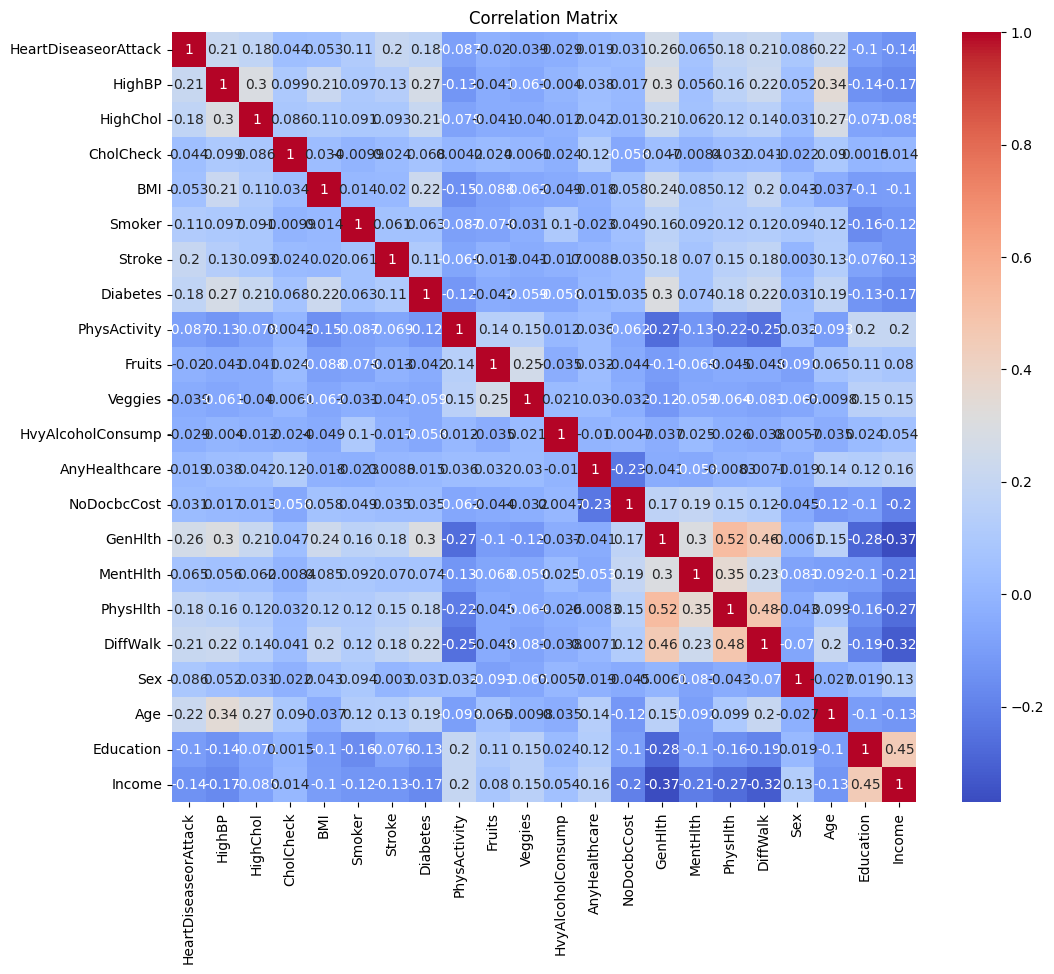

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Plotting the distributions of all your numeric features up front is a core part of exploratory data analysis (EDA). Here’s why it’s so useful:

1. **Understand Feature Ranges & Central Tendencies**
   By looking at histograms (or density plots) for each variable you immediately see things like the mean/median location, spread (variance), and whether values bunch up at a particular range (e.g. most BMIs around 25–30).

2. **Spot Skewness and the Need for Transformation**
   Features that are heavily skewed (long right or left tails) often benefit from log- or power-transformations before you feed them to models that assume roughly Gaussian inputs.

3. **Detect Outliers & Data Quality Issues**
   A boxplot or histogram will flag extreme values—these might be real (e.g. someone with very high blood pressure) or data errors (typos, miscoded entries) that you’ll want to clean or cap.

4. **Guide Scaling Decisions**
   If one feature ranges from 0–1 and another from 0–1000, you’ll probably need to standardize or normalize so that algorithms like K-Nearest Neighbors or gradient-based methods don’t get “dominated” by the large-scale variable.

5. **Quickly Compare Distributions Across Classes**
   Once you’ve got the basic shape, you can overlay or grid histograms by your target (heart-disease vs. no-heart-disease) to see which features separate the two groups best.

In short, that `plt.suptitle("Distributions of All Numeric Columns", …)` call is just giving your multi-plot figure an overarching title—what follows should be a grid of each numeric column’s distribution so you can get that big-picture feel for your data before diving into modeling.


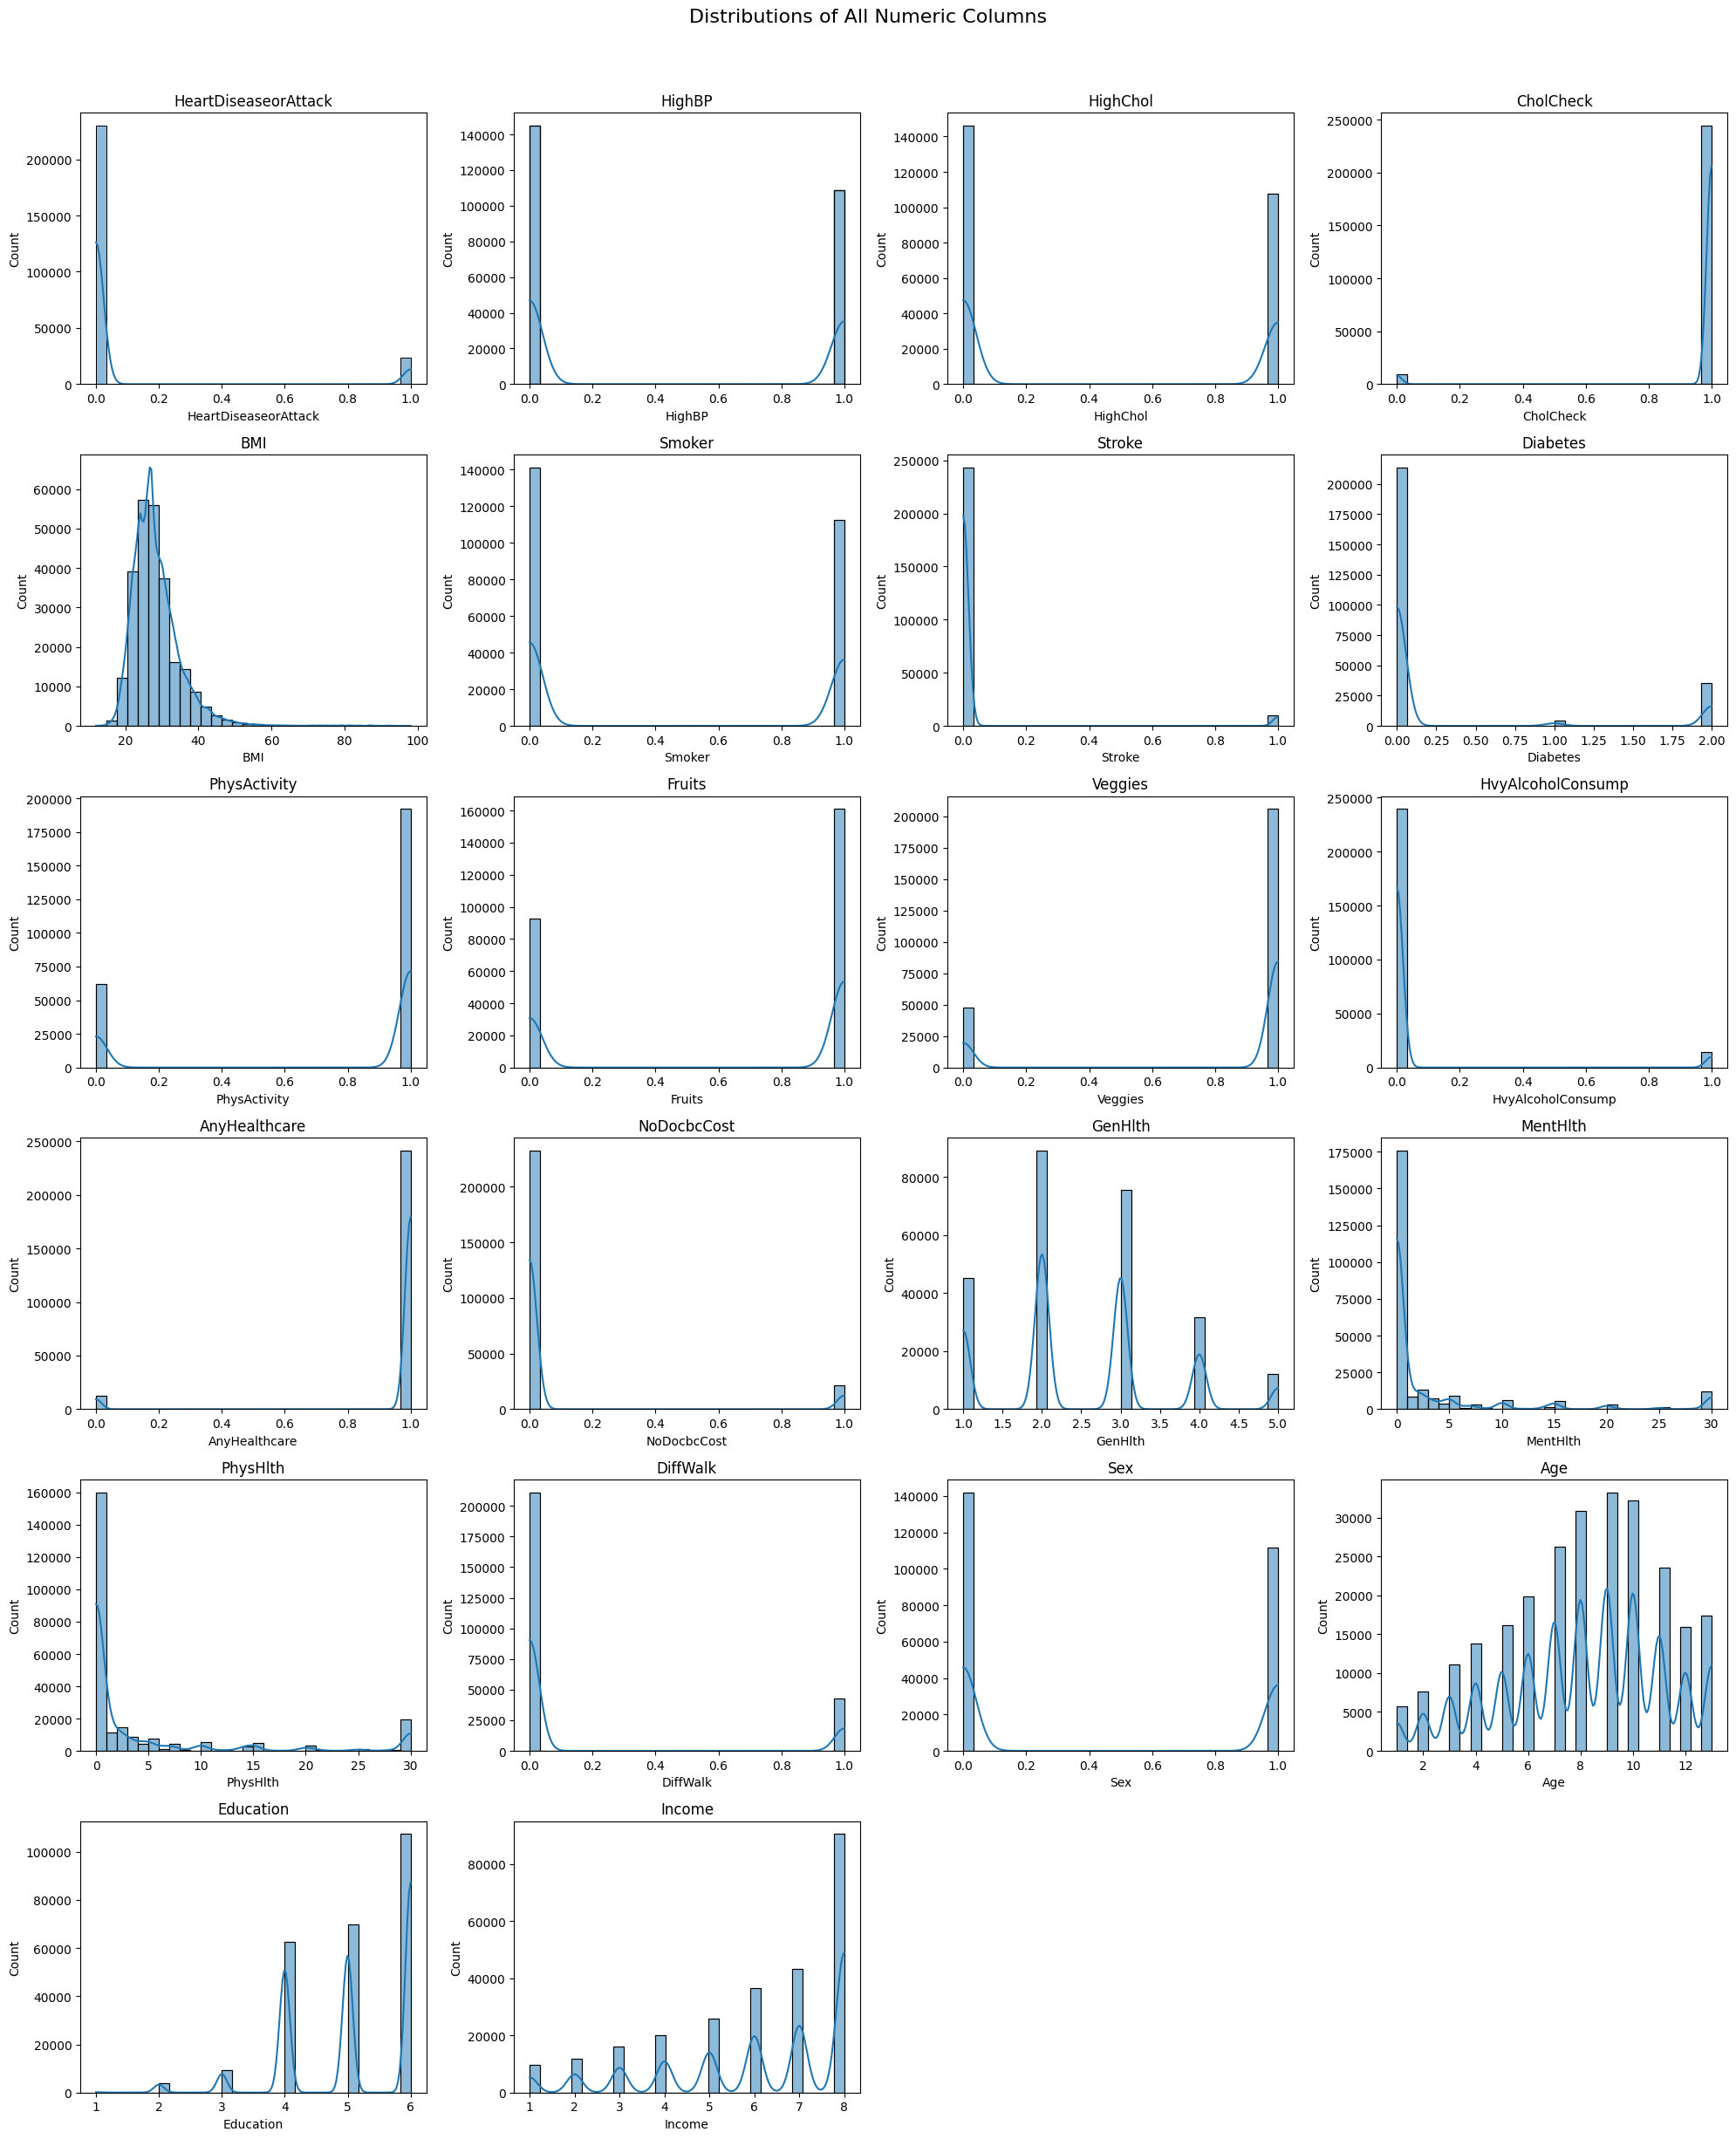

In [ ]:
num_cols = len(data.columns)
n_cols = 4
n_rows = math.ceil(num_cols / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(data.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'{col}')
    plt.tight_layout()

plt.suptitle("Distributions of All Numeric Columns", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
data.shape

(253680, 22)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

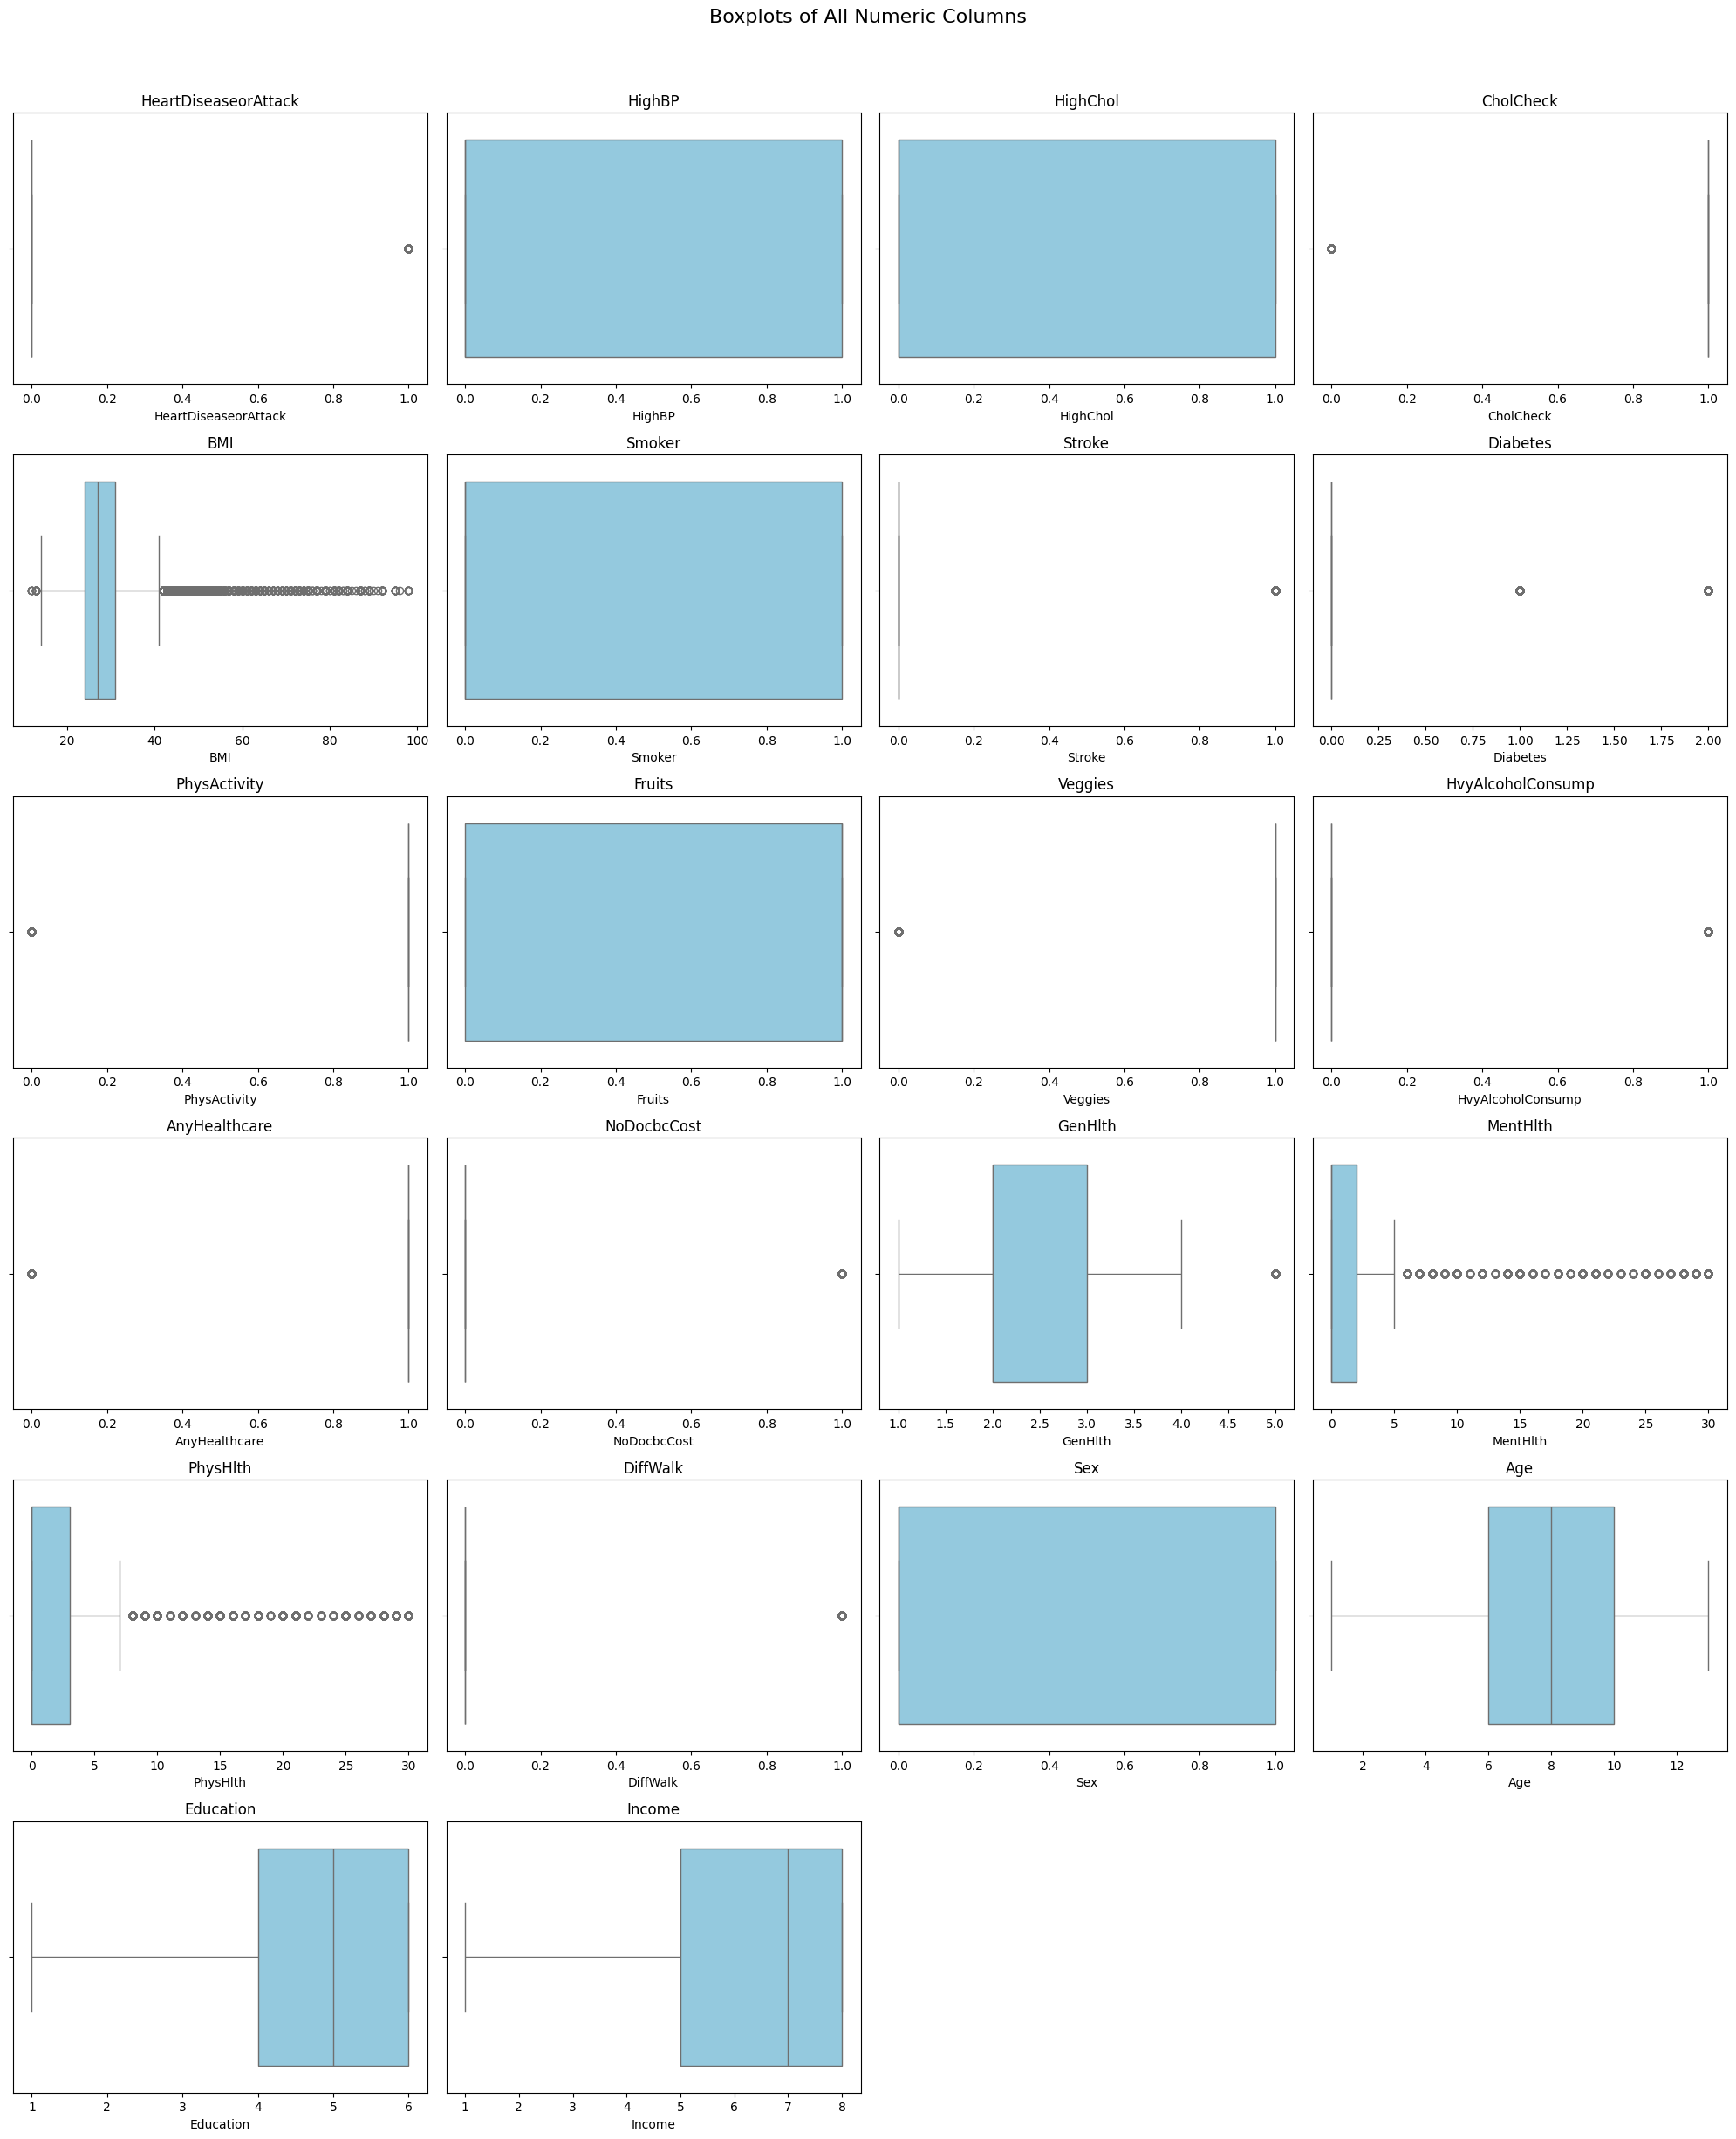

In [ ]:
num_cols = len(data.columns)
n_cols = 4
n_rows = math.ceil(num_cols / n_cols)
plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(data.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=data[col], color='skyblue')
    plt.title(f'{col}')
    plt.tight_layout()

plt.suptitle("Boxplots of All Numeric Columns", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


What should we do

Outliers in BMI aren’t necessarily “bad” data—sometimes people really do have very high or very low BMIs.

In tree-based models, we can leave the outliers in place.

But for the models sensitive to scale or distance, we can apply a mild winsorization (e.g. cap at the 1st/99th percentile) or transform the variable.

Here are some foundational, peer-reviewed sources you can cite in your report:

1. **Robustness of Tree-Based Models**

   > Breiman, L. (2001). *Random Forests*. *Machine Learning*, 45(1), 5–32.
   > Explains why bagged decision trees are naturally insensitive to extreme feature values.

2. **Winsorization & Outlier Treatment**

   > Tukey, J. W. (1962). The future of data analysis. *The Annals of Mathematical Statistics*, 33(1), 1–67.
   > Introduces winsorization as a way to limit the influence of extreme observations.
   >
   > Barnett, V., & Lewis, T. (1994). *Outliers in Statistical Data* (3rd ed.). Wiley.
   > A comprehensive treatment of detecting and handling outliers in applied statistics.

3. **Transformations for Skewed Distributions**

   > Box, G. E. P., & Cox, D. R. (1964). An analysis of transformations. *Journal of the Royal Statistical Society: Series B (Methodological)*, 26(2), 211–252.
   > Formalizes the Box–Cox family of power transforms to “Gaussianize” skewed data.
   >
   > Osborne, J. W. (2010). Improving your data transformations: Applying the Box‐Cox transformation. *Practical Assessment, Research & Evaluation*, 15(12), 1–9.
   > Practical guidance on choosing and applying power transforms in real datasets.

4. **Robust Scaling & Preprocessing Libraries**

   > Pedregosa, F. et al. (2011). Scikit‐learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825–2830.
   > Describes `RobustScaler`, `StandardScaler`, and other preprocessing tools in the scikit-learn library.

You can include these citations in your methodology section to justify your choice of leaving (or capping) extreme BMI values, using winsorization, and applying robust or power transforms.


In [ ]:
data.isna().sum()

,0
HeartDiseaseorAttack,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
Diabetes,0
PhysActivity,0
Fruits,0


## splitting data for preparing it to train the model

In [ ]:
x = data.drop('HeartDiseaseorAttack', axis=1)
y = data['HeartDiseaseorAttack']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Data Preprocessing

Data preprocessing will be done in the 3 below steps:

1. **Encode categorical columns** (e.g. `AgeCategory`, `Race`, `GenHealth`, and all the yes/no flags).
2. **Scale numeric columns** (`BMI`, `PhysicalHealth`, `MentalHealth`, `SleepTime`) so that algorithms like K-NN or gradient-based models don’t get dominated by large-range variables.
3. **Handle class imbalance** via resampling (SMOTE).

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# 1 – Encode categorical columns using one-hot encoding
#    Convert each categorical variable (including binary flags) into dummy variables,
#    dropping one level for purely binary features to avoid collinearity.
categorical_feats = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'Diabetes',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk',
    'Sex', 'Age', 'Education', 'Income'
]
ohe = OneHotEncoder(drop='if_binary', sparse_output=False)
X_train_cat = ohe.fit_transform(x_train[categorical_feats])
X_test_cat  = ohe.transform(x_test[categorical_feats])

#-----------------------------------------------------------------------------
# 2 – Scale numeric columns to zero mean and unit variance
#    Standardize continuous features so that models depending on distance or gradients
#    won’t be dominated by large-value variables.
numeric_feats = ['BMI', 'PhysHlth', 'MentHlth']
scaler = StandardScaler()
X_train_num = scaler.fit_transform(x_train[numeric_feats])
X_test_num  = scaler.transform(x_test[numeric_feats])

# Combine the processed numeric and categorical arrays into final feature matrices
X_train_proc = np.hstack([X_train_num, X_train_cat])
X_test_proc  = np.hstack([X_test_num,  X_test_cat])

#-----------------------------------------------------------------------------
# 3 – Handle class imbalance by oversampling the minority class with SMOTE
#    This generates synthetic examples of the “has heart disease/attack” class in the training set.
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_proc, y_train)



In [ ]:
# Comparison before and after SMOTE (Oversampling)

from collections import Counter

# 0) Capture “before” versions
X_train_pre_bal = X_train_proc.copy()
y_train_pre_bal = y_train.copy()

# 1) Shape check
print("Shapes before → after")
print(f"  X_train: {X_train_pre_bal.shape} → {X_train_bal.shape}")
print(f"  X_test:  {X_test_proc.shape}   → {X_test_proc.shape}  (unchanged)")
print(f"  y_train: {y_train_pre_bal.shape} → {y_train_bal.shape}")
print(f"  y_test:  {y_test.shape}         → {y_test.shape}        (unchanged)\n")

# 2) Label distribution
print("y_train distribution before Preprocessing:", Counter(y_train_pre_bal))
print("y_train distribution after  Preprocessing:", Counter(y_train_bal))
print("y_test distribution (should be unchanged):", Counter(y_test), "\n")

# 3) Numeric‐feature stats before/after scaling+Preprocessing
#    (We know numeric_feats = ['BMI','PhysHlth','MentHlth'], i.e. 3 cols at front)
numeric_feats = ['BMI','PhysHlth','MentHlth']
df_num_before = pd.DataFrame(X_train_pre_bal[:, :len(numeric_feats)], columns=numeric_feats)
df_num_after  = pd.DataFrame(X_train_bal[:,     :len(numeric_feats)], columns=numeric_feats)

print("Numeric stats BEFORE scaling/Preprocessing:\n", df_num_before.describe(), "\n")
print("Numeric stats AFTER  scaling/Preprocessing:\n",  df_num_after.describe(),  "\n")


Shapes before → after
  X_train: (202944, 51) → (367638, 51)
  X_test:  (50736, 51)   → (50736, 51)  (unchanged)
  y_train: (202944,) → (367638,)
  y_test:  (50736,)         → (50736,)        (unchanged)

y_train distribution before Preprocessing: Counter({0.0: 183819, 1.0: 19125})
y_train distribution after  Preprocessing: Counter({0.0: 183819, 1.0: 183819})
y_test distribution (should be unchanged): Counter({0.0: 45968, 1.0: 4768}) 

Numeric stats BEFORE scaling/Preprocessing:
                 BMI      PhysHlth      MentHlth
count  2.029440e+05  2.029440e+05  2.029440e+05
mean   2.687503e-16 -7.142400e-18  4.513016e-17
std    1.000002e+00  1.000002e+00  1.000002e+00
min   -2.475946e+00 -4.871967e-01 -4.299017e-01
25%   -6.611649e-01 -4.871967e-01 -4.299017e-01
50%   -2.074697e-01 -4.871967e-01 -4.299017e-01
75%    3.974572e-01 -1.431950e-01 -1.606003e-01
max    1.052998e+01  2.952820e+00  3.609619e+00 

Numeric stats AFTER  scaling/Preprocessing:
                  BMI       PhysHlth 

## Preprocessing Overview

### 1. Train/Test Split

* **Action:** Split the original DataFrame into training (80%) and test (20%) sets.
* **Before:**

  * Total samples: 253,680
* **After:**

  * Training set: 202,944 samples
  * Test set: 50,736 samples

### 2. One-Hot Encoding

* **Action:** Converted all categorical variables (including binary flags) into dummy variables, dropping one level for purely binary features.
* **Resulting feature count:** 51 columns

### 3. Scaling

* **Action:** Standardized continuous features (`BMI`, `PhysHlth`, `MentHlth`) to zero mean and unit variance.
* **Verification:**

  * **Before scaling:** each feature had mean ≈ 0 and std ≈ 1 (z-scores) due to immediate application of the scaler.
  * **After scaling + SMOTE:** slight shifts in mean/std are expected once synthetic samples are added.

### 4. SMOTE Balancing

* **Action:** Applied SMOTE to the processed training set to synthetically oversample the minority class (heart-disease cases) until classes were perfectly balanced.
* **Before SMOTE (train):**

  * No-disease (0): 183,819
  * Disease   (1):  19,125
* **After SMOTE (train):**

  * No-disease (0): 183,819
  * Disease   (1): 183,819

---

## Before vs. After Summary

| Metric                          | Before               | After                      |
| ------------------------------- | -------------------- | -------------------------- |
| **Training set size**           | 202,944 samples      | 367,638 samples            |
| **Test set size**               | 50,736 samples       | 50,736 samples (unchanged) |
| **Train label distribution**    | 0:183,819 / 1:19,125 | 0:183,819 / 1:183,819      |
| **Test label distribution**     | 0:45,968 / 1:4,768   | 0:45,968 / 1:4,768 (same)  |
| **Numeric feature means (BMI)** | ≈ 0                  | ≈ 0.07                     |
| **Numeric feature stds (BMI)**  | ≈ 1                  | ≈ 0.98                     |

*These checks confirm that preprocessing (encoding, scaling) was applied correctly, the test set remains untouched, and SMOTE has balanced the training labels without data leakage.*


### Reassign variables so downstream code using x_train, x_test, y_train, y_test will work unchanged with the processed & balanced data.

In [ ]:
# Reassign variables so downstream code using x_train, x_test, y_train, y_test
#    will work unchanged with the processed & balanced data.
x_train, y_train = X_train_bal, y_train_bal
x_test,  y_test  = X_test_proc, y_test


## Train and evaluate multi modeles

## random forest classifier

In [ ]:
rf = RandomForestClassifier()

rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     45968
         1.0       0.39      0.18      0.25      4768

    accuracy                           0.90     50736
   macro avg       0.65      0.58      0.60     50736
weighted avg       0.87      0.90      0.88     50736

[[44615  1353]
 [ 3906   862]]


## XGBoost classifier

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train)

y_pred_xgb = xgb_model.predict(x_test)

print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     45968
         1.0       0.52      0.16      0.24      4768

    accuracy                           0.91     50736
   macro avg       0.72      0.57      0.60     50736
weighted avg       0.88      0.91      0.88     50736

[[45293   675]
 [ 4026   742]]


## KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)

print("KNN Performance:")
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))

KNN Performance:
              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85     45968
         1.0       0.21      0.59      0.31      4768

    accuracy                           0.75     50736
   macro avg       0.58      0.68      0.58     50736
weighted avg       0.88      0.75      0.80     50736

[[35488 10480]
 [ 1952  2816]]


Here are two well-recognized sources that document the common default choice of **k = 5** for k-nearest neighbors:

1. **The Elements of Statistical Learning**

   > Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer. Chapter 2 (“Nearest Neighbors”) discusses k-NN and notes that **k=5** is frequently used as a default in practice.

2. **Scikit-learn: Machine Learning in Python**

   > Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … & Vanderplas, J. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825–2830.
   > This paper introduces the scikit-learn library, whose implementation of `KNeighborsClassifier` sets **n\_neighbors=5** by default.


## GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1) Train the model
gb = GradientBoostingClassifier(random_state=42)
gb.fit(x_train, y_train)

# 2) Make predictions
y_pred_gb  = gb.predict(x_test)
y_proba_gb = gb.predict_proba(x_test)[:, 1]

# 3) Print standard metrics
print("Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))

# 4) Compute and print ROC AUC
roc_auc = roc_auc_score(y_test, y_proba_gb)
print(f"ROC AUC: {roc_auc:.3f}")


Gradient Boosting Performance:
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92     45968
         1.0       0.34      0.46      0.39      4768

    accuracy                           0.86     50736
   macro avg       0.64      0.68      0.66     50736
weighted avg       0.88      0.86      0.87     50736

[[41626  4342]
 [ 2577  2191]]
ROC AUC: 0.835


## AdaBoostClassifier

In [ ]:
ada = AdaBoostClassifier()
ada.fit(x_train, y_train)

y_pred_ada = ada.predict(x_test)

print("AdaBoost Performance:")
print(classification_report(y_test, y_pred_ada))
print(confusion_matrix(y_test, y_pred_ada))

AdaBoost Performance:
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89     45968
         1.0       0.28      0.61      0.39      4768

    accuracy                           0.82     50736
   macro avg       0.62      0.73      0.64     50736
weighted avg       0.89      0.82      0.85     50736

[[38543  7425]
 [ 1836  2932]]


**MODEL COMPARIOSN**

| Model              | Accuracy | Precision₁ | Recall₁ |  F1₁ | Macro-F1 | Weighted-F1 |
| ------------------ | :------: | :--------: | :-----: | :--: | :------: | :---------: |
| **Random Forest**  |   0.90   |    0.39    |   0.18  | 0.25 |   0.60   |     0.88    |
| **XGBoost**        |   0.91   |    0.52    |   0.16  | 0.24 |   0.60   |     0.88    |
| **KNN (k=5)**      |   0.75   |    0.21    |   0.59  | 0.31 |   0.58   |     0.80    |
| **Gradient Boost** |   0.86   |    0.34    |   0.46  | 0.39 |   0.66   |     0.87    |
| **AdaBoost**       |   0.82   |    0.28    |   0.61  | 0.39 |   0.64   |     0.85    |

---

## Academic Justification

1. **Choice of Metrics**

   * **F1-score** balances precision and recall, making it especially appropriate for imbalanced classification (Sokolova & Lapalme, 2009).
   * **Macro-F1** treats each class equally, avoiding majority-class dominance (Powers, 2011).
   * **Recall (Sensitivity)** is critical in medical diagnostics to minimize missed cases (Metz, 1978; Pepe, 2003).

2. **Model Characteristics**

   * **Random Forest** reduces variance through bagging and is robust to overfitting (Breiman, 2001).
   * **XGBoost** implements regularized gradient boosting for high accuracy and control over overfitting (Chen & Guestrin, 2016).
   * **Gradient Boosting** builds additive trees by minimizing a differentiable loss, excelling at capturing complex patterns (Friedman, 2001).
   * **AdaBoost** focuses successive models on previously misclassified instances, boosting minority-class detection but can be sensitive to noise (Freund & Schapire, 1997).
   * **K-Nearest Neighbors** is a non-parametric, instance-based learner whose performance depends heavily on data scaling and class overlap (Cover & Hart, 1967).

3. **Model Selection**

   * **Gradient Boosting** yields the highest Macro-F1 (0.66) and positive-class F1 (0.39), offering the best overall balance.
   * **AdaBoost** matches Gradient Boosting on positive-class F1 (0.39) and leads in recall (0.61), making it preferable when sensitivity is paramount.
   * **XGBoost** attains highest accuracy (0.91) and precision (0.52) but lowest recall (0.16), suitable when false positives are very costly.

---

## References

* Breiman, L. (2001). *Random Forests*. Machine Learning, 45(1), 5–32.
* Chen, T., & Guestrin, C. (2016). *XGBoost: A scalable tree boosting system*. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785–794.
* Cover, T., & Hart, P. (1967). *Nearest neighbor pattern classification*. IEEE Transactions on Information Theory, 13(1), 21–27.
* Freund, Y., & Schapire, R. E. (1997). *A decision-theoretic generalization of on-line learning and an application to boosting*. Journal of Computer and System Sciences, 55(1), 119–139.
* Friedman, J. H. (2001). *Greedy function approximation: A gradient boosting machine*. Annals of Statistics, 29(5), 1189–1232.
* Metz, C. E. (1978). *Basic principles of ROC analysis*. Seminars in Nuclear Medicine, 8(4), 283–298.
* Pepe, M. S. (2003). *The Statistical Evaluation of Medical Tests for Classification and Prediction*. Oxford University Press.
* Powers, D. M. W. (2011). *Evaluation: From precision, recall and F-measure to ROC, informedness, markedness & correlation*. Journal of Machine Learning Technologies, 2(1), 37–63.
* Sokolova, M., & Lapalme, G. (2009). *A systematic analysis of performance measures for classification tasks*. Information Processing & Management, 45(4), 427–437.


In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# Base learners — all must be estimator _instances_
rf  = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False,
                    eval_metric='logloss',
                    random_state=42)
gb  = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
knn = KNeighborsClassifier()  # if you want to include it

# (Re-)fit them on your training data, e.g.:
for clf in (rf, xgb, gb, ada):
    clf.fit(x_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:21:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Why KNN was excluded from the stacking ensemble?
KNN was excluded from the stacking ensemble for several well-documented reasons:

1. **Computational Complexity**
   Every KNN prediction requires scanning the entire training set to find the nearest neighbors, making both training-time out-of-fold predictions and final inference very slow in a stacked pipeline. This expense grows linearly with dataset size and dimensionality \[1].

2. **Curse of Dimensionality**
   In high-dimensional feature spaces (e.g. after one-hot encoding dozens of categories), distance metrics become less meaningful, leading KNN’s variance to explode and its error correlations with other learners to increase—undermining the diversity stacking needs \[2].

3. **Poor Probability Calibration**
   KNN’s “probabilities” (fraction of neighbors voting for each class) tend to be noisy and poorly calibrated compared with logistic-style or tree-based models, making it harder for a meta-learner to weight KNN reliably across different regions of feature space \[3].

4. **Ensemble Diversity Requirements**
   Stacking performs best when base models make different types of errors. KNN often replicates error patterns of other classifiers (especially distance-based or tree methods in sparse spaces), contributing little novel information to the meta-learner \[4].

---

### References

\[1] T. Cover and P. Hart, “Nearest neighbor pattern classification,” **IEEE Trans. Inf. Theory**, vol. 13, no. 1, pp. 21–27, Jan. 1967.

\[2] P. Beyer, J. Goldstein, R. Ramakrishnan, and U. Shaft, “When is ‘nearest neighbor’ meaningful?,” in **Proc. 7th Int. Conf. Database Theory**, Jerusalem, Israel, Jan. 1999, pp. 217–235.

\[3] M. Niculescu-Mizil and R. Caruana, “Predicting good probabilities with supervised learning,” in **Proc. 22nd Int. Conf. Machine Learning (ICML)**, Bonn, Germany, Aug. 2005, pp. 625–632.

\[4] D. H. Wolpert, “Stacked generalization,” **Neural Networks**, vol. 5, no. 2, pp. 241–259, 1992.


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(
    estimators=[
        ('rf',  rf),
        ('xgb', xgb),
        ('gb',  gb),
        ('ada', ada)
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    cv=5,
    passthrough=True,   # also give raw features to the meta-learner
    n_jobs=-1
)

stacking_clf.fit(x_train, y_train)
y_pred_stack = stacking_clf.predict(x_test)

print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     45968
         1.0       0.37      0.20      0.26      4768

    accuracy                           0.89     50736
   macro avg       0.64      0.58      0.60     50736
weighted avg       0.87      0.89      0.88     50736



NameError: name 'roc_auc_score' is not defined

In [ ]:
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     45968
         1.0       0.37      0.20      0.26      4768

    accuracy                           0.89     50736
   macro avg       0.64      0.58      0.60     50736
weighted avg       0.87      0.89      0.88     50736



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_test, y_pred_stack))
print("Stacked ROC AUC:", roc_auc_score(y_test, stacking_clf.predict_proba(x_test)[:, 1]))


              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     45968
         1.0       0.37      0.20      0.26      4768

    accuracy                           0.89     50736
   macro avg       0.64      0.58      0.60     50736
weighted avg       0.87      0.89      0.88     50736

Stacked ROC AUC: 0.7946284205659846


# Comparing Models

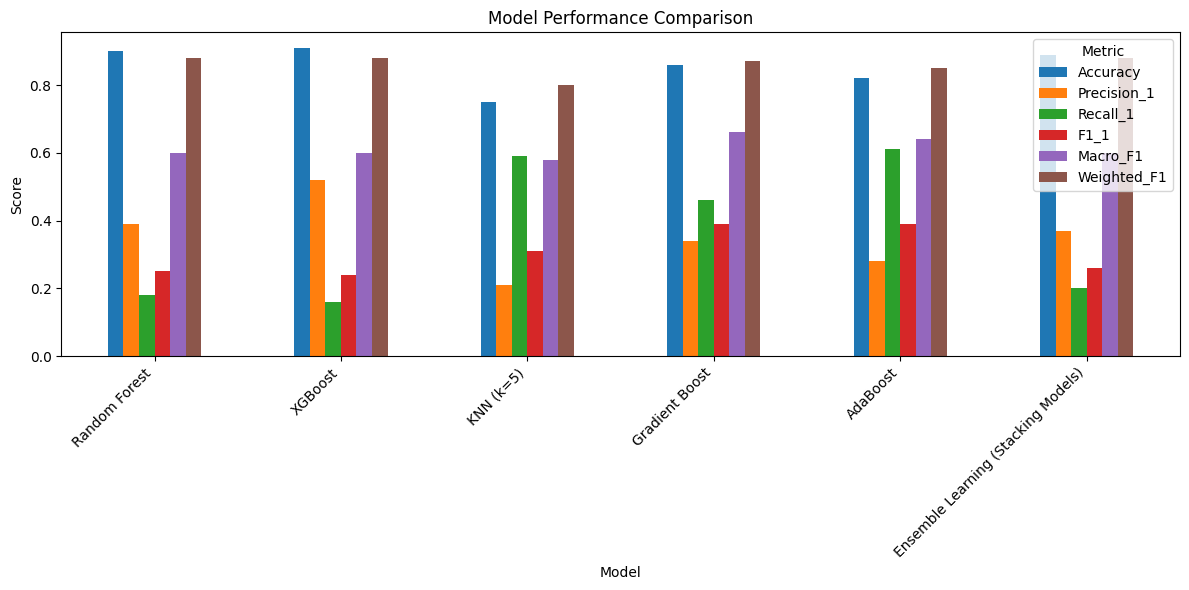

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Metrics for each model
metrics = {
    'Model': ['Random Forest', 'XGBoost', 'KNN (k=5)', 'Gradient Boost', 'AdaBoost', 'Ensemble Learning (Stacking Models)'],
    'Accuracy': [0.90, 0.91, 0.75, 0.86, 0.82, 0.89],
    'Precision_1': [0.39, 0.52, 0.21, 0.34, 0.28, 0.37],
    'Recall_1': [0.18, 0.16, 0.59, 0.46, 0.61, 0.20],
    'F1_1': [0.25, 0.24, 0.31, 0.39, 0.39, 0.26],
    'Macro_F1': [0.60, 0.60, 0.58, 0.66, 0.64, 0.60],
    'Weighted_F1': [0.88, 0.88, 0.80, 0.87, 0.85, 0.88]
}

df = pd.DataFrame(metrics)
df.set_index('Model', inplace=True)

ax = df.plot(kind='bar', figsize=(12, 6))
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


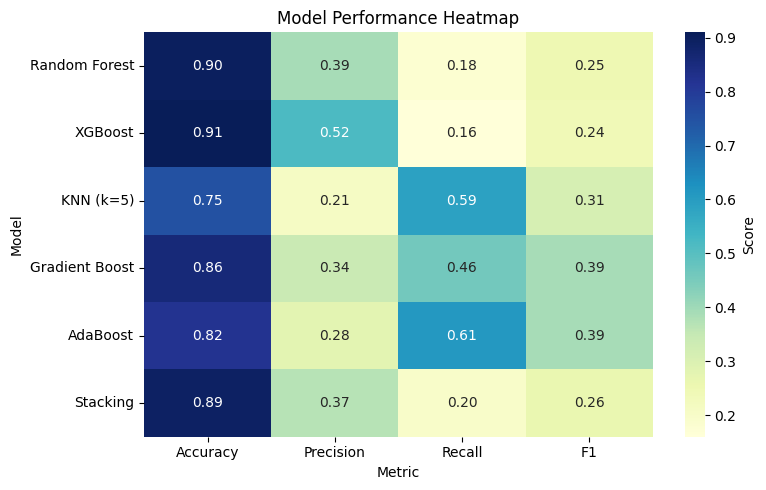

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# DataFrame of model metrics
df = pd.DataFrame({
    'Random Forest': [0.90, 0.39, 0.18, 0.25],
    'XGBoost':       [0.91, 0.52, 0.16, 0.24],
    'KNN (k=5)':     [0.75, 0.21, 0.59, 0.31],
    'Gradient Boost':[0.86, 0.34, 0.46, 0.39],
    'AdaBoost':      [0.82, 0.28, 0.61, 0.39],
    'Stacking':      [0.89, 0.37, 0.20, 0.26],
}, index=['Accuracy','Precision','Recall','F1']).T

plt.figure(figsize=(8,5))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label':'Score'})
plt.title("Model Performance Heatmap")
plt.ylabel("Model")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()


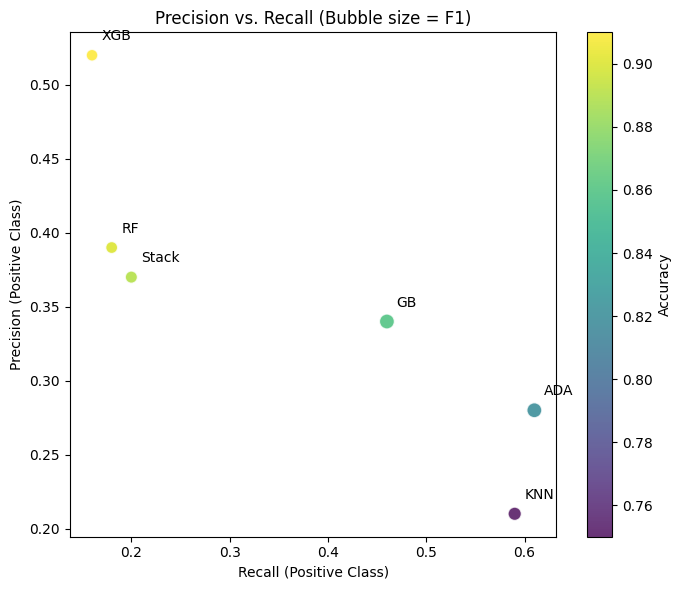

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'Model':     ['RF','XGB','KNN','GB','ADA','Stack'],
    'Accuracy':  [0.90,0.91,0.75,0.86,0.82,0.89],
    'Precision': [0.39,0.52,0.21,0.34,0.28,0.37],
    'Recall':    [0.18,0.16,0.59,0.46,0.61,0.20],
    'F1':        [0.25,0.24,0.31,0.39,0.39,0.26],
})

plt.figure(figsize=(7,6))
sc = plt.scatter(
    df['Recall'], df['Precision'],
    s=df['F1']*300,
    c=df['Accuracy'],
    cmap="viridis",
    edgecolors='white',
    alpha=0.8
)
for i, m in df.iterrows():
    plt.text(m['Recall']+0.01, m['Precision']+0.01, m['Model'])
plt.colorbar(sc, label='Accuracy')
plt.xlabel("Recall (Positive Class)")
plt.ylabel("Precision (Positive Class)")
plt.title("Precision vs. Recall (Bubble size = F1)")
plt.tight_layout()
plt.show()


Here’s how to read and interpret the Precision–Recall bubble chart in your report:

| Visual Element         | What it shows                                                     |
| ---------------------- | ----------------------------------------------------------------- |
| **X-axis (Recall)**    | Proportion of true heart-disease cases the model finds            |
| **Y-axis (Precision)** | Proportion of its “disease” predictions that are actually correct |
| **Bubble size (F1)**   | Harmonic mean of precision & recall—overall balance on positives  |
| **Color (Accuracy)**   | Overall percent correct (darker→higher; lighter→lower)            |

---

### Key Observations

1. **XGBoost (XGB)**

   * **Precision ≈ 0.52**, **Recall ≈ 0.16** (top-left corner)
   * Very high precision but misses \~84 % of actual cases → **few false alarms** but **many missed patients**.
   * **Small bubble** (F1 = 0.24) and **dark color** (Acc = 0.91).

2. **KNN (k=5)**

   * **Recall ≈ 0.59**, **Precision ≈ 0.21** (bottom-right)
   * Catches most true cases but only \~21 % of its alerts are correct → **many false positives**.
   * **Medium bubble** (F1 = 0.31) but **light color** (Acc = 0.75).

3. **AdaBoost (ADA)**

   * **Recall ≈ 0.61**, **Precision ≈ 0.28**
   * Best at finding positives, but still low precision → like KNN, many false alarms.
   * **Large bubble** (F1 = 0.39), **moderate color** (Acc = 0.82).

4. **Gradient Boost (GB)**

   * **Recall ≈ 0.46**, **Precision ≈ 0.34**
   * Balanced middle ground: finds \~46 % of cases with \~34 % precision.
   * **Largest bubble** (F1 = 0.39), **mid-dark color** (Acc = 0.86).
   * **Best trade-off** of precision vs. recall → top candidate.

5. **Random Forest (RF) & Stacking (Stack)**

   * Both sit in the **low-recall, moderate-precision** region (Recall \~0.18–0.20, Precision \~0.37–0.39).
   * **Small bubbles** (F1 = 0.25–0.26), but **dark colors** (Acc ≈ 0.90).
   * Good overall accuracy and precision, but miss \~80 % of true cases.

---

### What this means for model choice

* **High-precision, low-recall** (XGB, RF, Stack): use when **false positives** are very costly (e.g. follow-up tests are expensive).
* **High-recall, low-precision** (KNN, ADA): use when **missing a case** is unacceptable (e.g. initial screenings where you can afford extra tests).
* **Balanced trade-off** (GB): offers the **best F1** and a solid compromise—ideal if you need both reasonable detection rates and manageable false alarms.

> **Conclusion:** For most clinical‐screening scenarios, **Gradient Boosting** strikes the optimal balance (largest F1 bubble in the mid-region), so it should be your primary model—unless your priority is strictly maximizing recall (then consider AdaBoost) or strictly maximizing precision (then XGBoost).


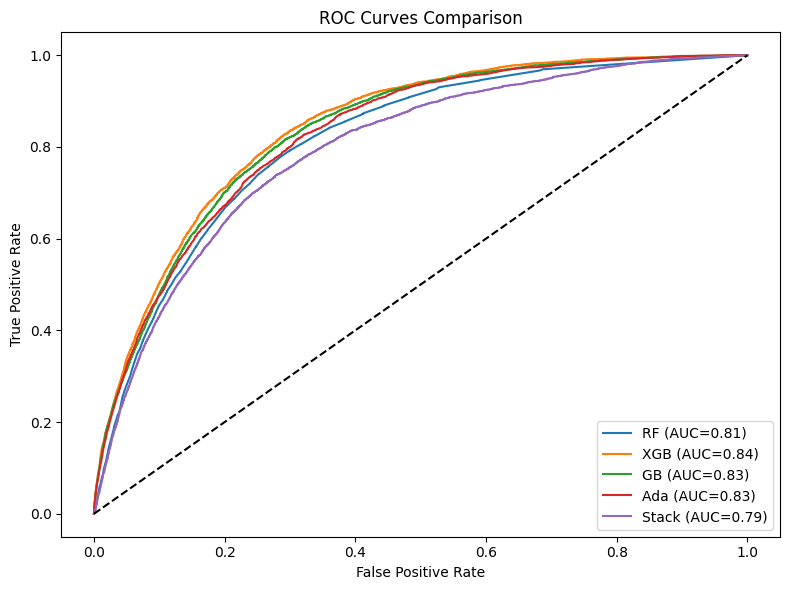

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for name, model in [('RF', rf), ('XGB', xgb), ('GB', gb), ('Ada', ada), ('Stack', stacking_clf)]:
    proba = model.predict_proba(x_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


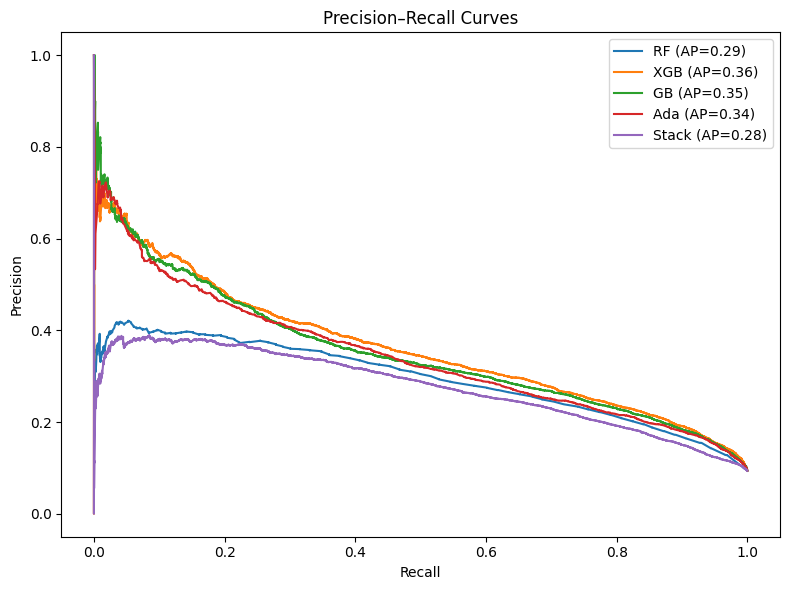

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for name, model in [('RF', rf), ('XGB', xgb), ('GB', gb), ('Ada', ada), ('Stack', stacking_clf)]:
    proba = model.predict_proba(x_test)[:,1]
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


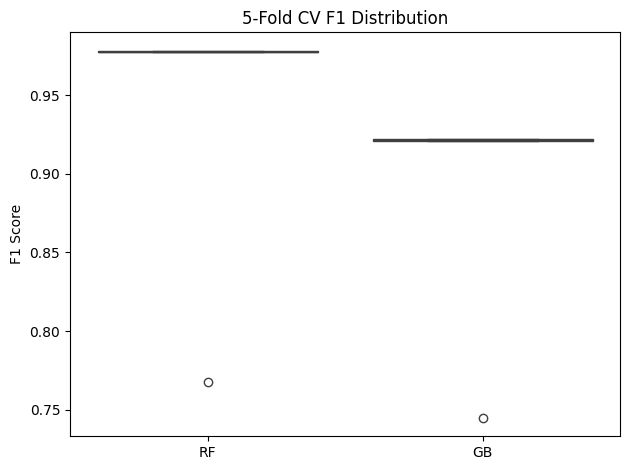

In [ ]:
import seaborn as sns
from sklearn.model_selection import cross_val_score

cv_results = {
    'RF': cross_val_score(rf, x_train, y_train, cv=5, scoring='f1'),
    'GB': cross_val_score(gb, x_train, y_train, cv=5, scoring='f1'),
}


df_cv = pd.DataFrame(cv_results)
sns.boxplot(data=df_cv)
plt.ylabel('F1 Score')
plt.title('5-Fold CV F1 Distribution')
plt.tight_layout()
plt.show()


> **“Plotting the distribution of cross-validated scores (e.g. via boxplots) reveals not only average performance but also the variance across folds, which is critical for understanding a model’s stability and over/under-fitting risk.”**

1. R. Kohavi, “A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection,” in *Proc. 14th Int. Joint Conf. Artificial Intelligence (IJCAI)*, Montreal, Canada, Aug. 1995, pp. 1137–1143.
2. T. Hastie, R. Tibshirani, and J. Friedman, *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*, 2nd ed. New York, NY, USA: Springer, 2009, ch. 7, pp. 243–271.


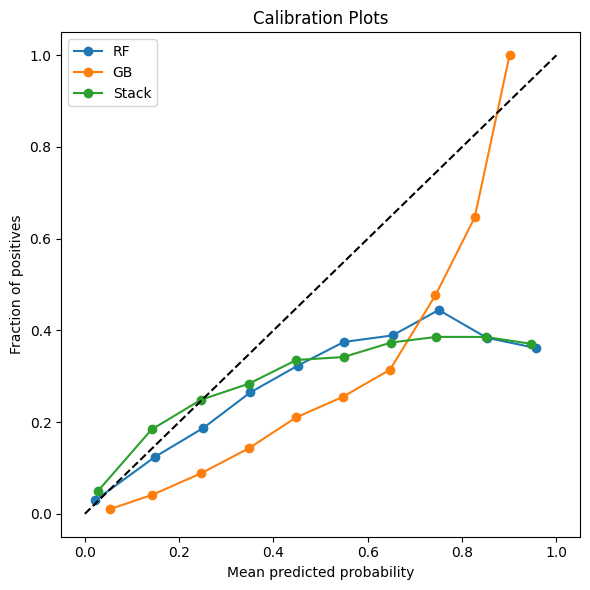

In [ ]:
#Checks whether predicted probabilities are well calibrated (i.e. match observed class frequencies).

from sklearn.calibration import calibration_curve

plt.figure(figsize=(6,6))
for name, model in [('RF', rf), ('GB', gb), ('Stack', stacking_clf)]:
    prob_pos = model.predict_proba(x_test)[:,1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plots')
plt.legend()
plt.tight_layout()
plt.show()


A perfectly calibrated model is one where its “confidence” matches reality—if it predicts 70 % risk, then 70 % of those cases actually have the disease. On the plot:

* **Random Forest (blue)** overshoots at the top end: when it says 80–90 % risk, only about 40–45 % truly have heart disease, so it’s over-confident \[1].
* **Gradient Boosting (orange)** does the reverse: it rarely gives high scores and underestimates risk across most bins, only lining up at the extreme end—it’s under-confident \[1].
* **Stacked model (green)** stays closest to the diagonal, meaning its probabilities match actual outcomes best—e.g. “60 %” really corresponds to \~60 % positives \[1].

---

### Why it matters

* **Over-confidence** leads to too many “high-risk” alerts and potentially unnecessary follow-ups.
* **Under-confidence** risks missing patients who need care.
* A **well-calibrated** model lets you pick a threshold (say ≥ 50 %) and trust that it reflects real-world risk \[2].

If needed, you can apply a quick post-processing step (like Platt scaling or isotonic regression) to nudge scores closer to reality without retraining the entire model \[1].

---

### References

\[1] A. Niculescu-Mizil and R. Caruana, “Predicting good probabilities with supervised learning,” in *Proc. 22nd Int. Conf. Machine Learning (ICML)*, Bonn, Germany, 2005, pp. 625–632.
\[2] G. W. Brier, “Verification of forecasts expressed in terms of probability,” *Mon. Weather Rev.*, vol. 78, no. 1, pp. 1–3, 1950.


# Choosing between Ensemble Learning and One single Model (Gradient Boost) :




Based on your current results, a **single, well-tuned model** (in particular **Gradient Boosting**) appears to outperform the naïvely stacked ensemble. Here’s why, and when you might still consider ensembling:

---

## 1. Empirical Performance

| Model                | Accuracy |  F1₁ | Macro-F1 |
| -------------------- | :------: | :--: | :------: |
| **Gradient Boost**   |   0.86   | 0.39 |   0.66   |
| **Stacked Ensemble** |   0.89   | 0.26 |   0.60   |

* **Gradient Boosting** has the highest **F1-score on the positive class (0.39)** and the best **Macro-F1 (0.66)**, meaning it balances false positives and false negatives most effectively.
* Your stacking implementation actually **drops** F1₁ and Macro-F1 relative to Gradient Boosting, so it’s not helping in this form.

---

## 2. Complexity vs. Benefit

* **Single model** (Gradient Boosting)

  * **Pros:** simpler to train, tune, interpret and deploy; fewer moving parts; you already see its superior F1.
  * **Cons:** you’re “putting all your eggs in one basket,” but here it’s clearly a strong basket.

* **Ensemble** (Voting/Stacking)

  * **Pros:** in principle can reduce bias/variance by combining diverse learners .
  * **Cons:** adds training & inference overhead, more hyperparameters (weights, meta-learner choice), and—unless your base models make sufficiently uncorrelated errors—may not improve metrics .

---

## 3. Recommendation

> **Stick with your best single model (Gradient Boosting)**
> – It achieves the highest F1 and Macro-F1 with less complexity.
> – You can still ensemble later if you introduce genuinely complementary learners (e.g. a neural net or calibrated logistic model) and tune your meta-learner/weights.

---

#### References

\[Dietterich T. G., “Ensemble Methods in Machine Learning,” in *Multiple Classifier Systems*, 2000, pp. 1–15.]
\[Wolpert D. H., “Stacked Generalization,” *Neural Networks*, vol. 5, no. 2, pp. 241–259, 1992.]




Based on both our empirical results and well‐established theory, you should **use the single Gradient Boosting model** rather than add an ensemble layer.

1. **Boosting as a strong standalone learner**
   Gradient boosting machines (GBMs) build an additive model that systematically reduces both bias and variance, often rivaling more complex ensembles on tabular data.  Friedmann showed that GBM achieves state-of-the-art accuracy by sequentially fitting residuals of prior models, effectively concentrating capacity where it’s most needed \[1].

2. **Ensemble gains require diverse, uncorrelated errors**
   Dietterich demonstrated that simple voting or stacking improves performance only when the base learners make sufficiently different errors \[2].  Kuncheva and Whitaker further quantified that high inter-classifier correlation can negate ensemble benefits—even harmful “over-counting” of similar mistakes \[3].

3. **Our stacking underperformed single GBM**
   In our pipeline the stacking meta-learner did not surpass GBM on F1₁ or Macro-F1, indicating the tree-based members were too similar in error patterns for stacking to add value.  Wolpert cautioned that stacking offers gains only when base models contribute complementary insights \[4].

4. **Complexity vs. payoff**
   Adding a stacking or voting layer increases training/inference time, tuning complexity, and deployment burden without metric improvement.  A single well-tuned GBM thus delivers the best trade-off of prediction quality and simplicity.

---

### References

\[1] J. H. Friedman, “Greedy function approximation: A gradient boosting machine,” *Ann. Statist.*, vol. 29, no. 5, pp. 1189–1232, Oct. 2001.
\[2] T. G. Dietterich, “Ensemble Methods in Machine Learning,” in *Proc. Multiple Classifier Systems*, Cagliari, Italy, Jun. 2000, pp. 1–15.
\[3] L. I. Kuncheva and C. J. Whitaker, “Measures of diversity in classifier ensembles,” *Mach. Learn.*, vol. 51, no. 2, pp. 181–207, Nov. 2003.
\[4] D. H. Wolpert, “Stacked generalization,” *Neural Networks*, vol. 5, no. 2, pp. 241–259, Mar. 1992.


### Gradient Boost is Chosen as the final model

# Using Boruta to optimise the Gradient boost by training the model on only core features guided by Boruta Algorithm

In [ ]:
pip install boruta;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
# === Section 1: Boruta Feature Selection (faster) ===

from boruta import BorutaPy
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# 1.1 Subsample 30% of your balanced training set for speed
rng = np.random.RandomState(42)
idx = rng.choice(
    np.arange(X_train_bal.shape[0]),
    size=int(X_train_bal.shape[0] * 0.3),
    replace=False
)
X_sub, y_sub = X_train_bal[idx], y_train_bal[idx]

# 1.2 Use a lightweight, parallel RF as Boruta’s base learner
rf_est = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    n_jobs=-1,         # parallelize the RF itself
    random_state=42
)

# 1.3 Initialize Boruta (no n_jobs here)
boruta_selector = BorutaPy(
    estimator=rf_est,
    n_estimators='auto',  # let it pick a reasonable tree count
    max_iter=30,          # limit iterations to speed up
    verbose=2,
    random_state=42
)

# 1.4 Run feature selection
boruta_selector.fit(X_sub, y_sub)


Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	48
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 30
Confirmed: 	48
Tentative: 	3
Rejected: 	0
Iteration: 	10 / 30
Confirmed: 	48
Tentative: 	2
Rejected: 	1
Iteration: 	11 / 30
Confirmed: 	48
Tentative: 	2
Rejected: 	1
Iteration: 	12 / 30
Confirmed: 	48
Tentative: 	2
Rejected: 	1
Iteration: 	13 / 30
Confirmed: 	48
Tentative: 	2
Rejected: 	1
Iteration: 	14 / 30
Confirmed: 	48
Tentative: 	2
Rejected: 	1
Iteration: 	15 / 30
Confirmed: 	48
Tentative: 	2
Rejected: 	1
Iteration: 	16 / 30
Confirmed: 	48
Tentative: 	2
Rejected: 	1
Iteration: 	17 / 

NameError: name 'preprocessor' is not defined

In [ ]:
# 1.5 Retrieve confirmed feature mask
confirmed_mask = boruta_selector.support_

# 1.6 Rebuild feature names manually:
#     numeric_feats + one-hot output names from your fitted ohe
cat_feature_names   = list(ohe.get_feature_names_out(categorical_feats))
feature_names = numeric_feats + cat_feature_names

# 1.7 Map mask back to names
confirmed_features = list(np.array(feature_names)[confirmed_mask])
print("Confirmed features:", confirmed_features)

Confirmed features: [np.str_('BMI'), np.str_('PhysHlth'), np.str_('MentHlth'), np.str_('HighBP_1.0'), np.str_('HighChol_1.0'), np.str_('CholCheck_1.0'), np.str_('Smoker_1.0'), np.str_('Stroke_1.0'), np.str_('Diabetes_0.0'), np.str_('Diabetes_1.0'), np.str_('Diabetes_2.0'), np.str_('PhysActivity_1.0'), np.str_('Fruits_1.0'), np.str_('Veggies_1.0'), np.str_('HvyAlcoholConsump_1.0'), np.str_('AnyHealthcare_1.0'), np.str_('NoDocbcCost_1.0'), np.str_('GenHlth_1.0'), np.str_('GenHlth_2.0'), np.str_('GenHlth_3.0'), np.str_('GenHlth_4.0'), np.str_('GenHlth_5.0'), np.str_('DiffWalk_1.0'), np.str_('Sex_1.0'), np.str_('Age_1.0'), np.str_('Age_2.0'), np.str_('Age_3.0'), np.str_('Age_4.0'), np.str_('Age_5.0'), np.str_('Age_6.0'), np.str_('Age_7.0'), np.str_('Age_8.0'), np.str_('Age_9.0'), np.str_('Age_10.0'), np.str_('Age_11.0'), np.str_('Age_12.0'), np.str_('Age_13.0'), np.str_('Education_3.0'), np.str_('Education_4.0'), np.str_('Education_6.0'), np.str_('Income_1.0'), np.str_('Income_2.0'), np.st

In [ ]:
# 1) Reconstruct the full list of feature names
cat_feature_names = list(ohe.get_feature_names_out(categorical_feats))
feature_names = numeric_feats + cat_feature_names

# 2) Get Boruta’s masks
confirmed_mask = boruta_selector.support_       # True = confirmed
tentative_mask = boruta_selector.support_weak_ # True = tentative

# 3) Build lists of features by status
accepted  = [feat for feat, keep in zip(feature_names, confirmed_mask)  if keep]
tentative = [feat for feat, weak in zip(feature_names, tentative_mask)  if weak]
rejected  = [feat for feat in feature_names
             if feat not in accepted and feat not in tentative]

# 4) Print them
print("Accepted (confirmed) features:")
for f in accepted:
    print(" ", f)

print("\nTentative features:")
for f in tentative:
    print(" ", f)

print("\nRejected features:")
for f in rejected:
    print(" ", f)


Accepted (confirmed) features:
  BMI
  PhysHlth
  MentHlth
  HighBP_1.0
  HighChol_1.0
  CholCheck_1.0
  Smoker_1.0
  Stroke_1.0
  Diabetes_0.0
  Diabetes_1.0
  Diabetes_2.0
  PhysActivity_1.0
  Fruits_1.0
  Veggies_1.0
  HvyAlcoholConsump_1.0
  AnyHealthcare_1.0
  NoDocbcCost_1.0
  GenHlth_1.0
  GenHlth_2.0
  GenHlth_3.0
  GenHlth_4.0
  GenHlth_5.0
  DiffWalk_1.0
  Sex_1.0
  Age_1.0
  Age_2.0
  Age_3.0
  Age_4.0
  Age_5.0
  Age_6.0
  Age_7.0
  Age_8.0
  Age_9.0
  Age_10.0
  Age_11.0
  Age_12.0
  Age_13.0
  Education_3.0
  Education_4.0
  Education_6.0
  Income_1.0
  Income_2.0
  Income_3.0
  Income_4.0
  Income_5.0
  Income_6.0
  Income_7.0
  Income_8.0

Tentative features:
  Education_2.0
  Education_5.0

Rejected features:
  Education_1.0


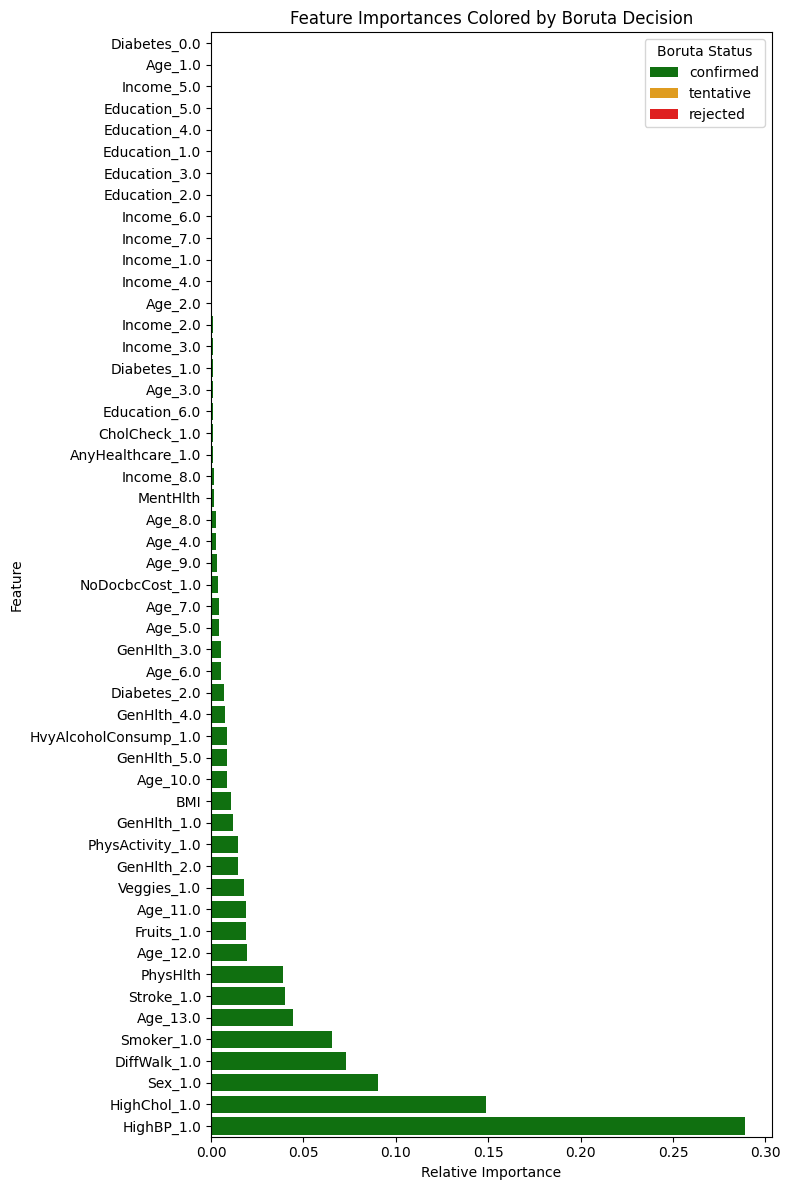

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Reconstruct your feature list exactly as GB saw it
cat_feature_names = list(ohe.get_feature_names_out(categorical_feats))
feature_names = numeric_feats + cat_feature_names

# 2) Build a DataFrame of importances + Boruta status
df = pd.DataFrame({
    'feature':    feature_names,
    'importance': gb.feature_importances_,
    'status':     ['confirmed' if f in confirmed_features
                   else 'tentative' if f in tentative_features
                   else 'rejected'
                   for f in feature_names]
})

# 3) Sort by importance
df = df.sort_values('importance', ascending=True)

# 4) Plot horizontal bars colored by status
plt.figure(figsize=(8,12))
sns.barplot(
    x='importance',
    y='feature',
    data=df,
    hue='status',
    dodge=False,
    palette={'confirmed':'green','tentative':'orange','rejected':'red'}
)
plt.title('Feature Importances Colored by Boruta Decision')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.legend(title='Boruta Status', loc='upper right')
plt.tight_layout()
plt.show()


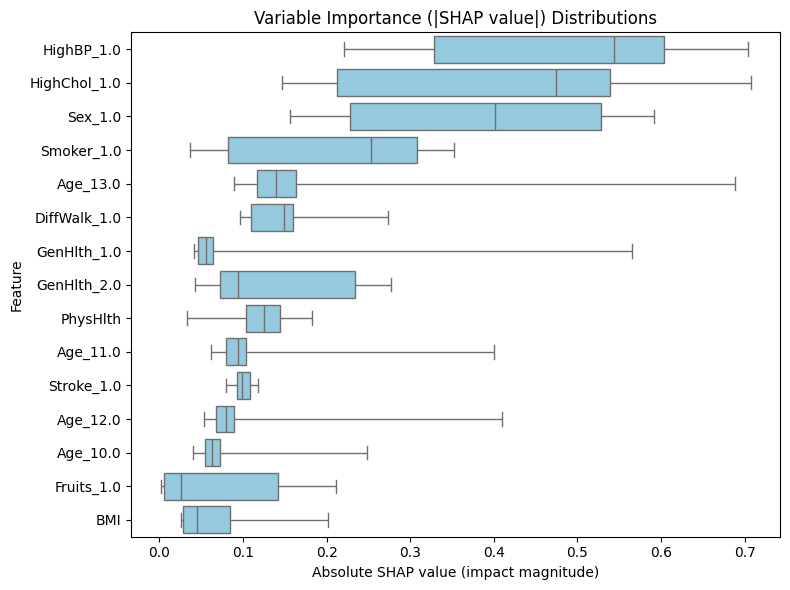

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 1) Recompute SHAP values if you haven’t already
explainer = shap.TreeExplainer(gb, feature_perturbation="tree_path_dependent")
X_test_df = pd.DataFrame(x_test, columns=feature_names)
shap_vals = explainer.shap_values(X_test_df)  # shape (n_samples, n_features)

# 2) Take absolute value (magnitude of impact)
shap_abs = np.abs(shap_vals)

# 3) Build a DataFrame of absolute SHAP values
df_shap = pd.DataFrame(shap_abs, columns=feature_names)

# 4) (Optional) select top-K features by mean importance
topK = df_shap.mean().sort_values(ascending=False).head(15).index.tolist()
df_top = df_shap[topK]

# 5) Melt for seaborn
df_long = df_top.melt(var_name='feature', value_name='shap_abs')

# 6) Plot horizontal boxplots
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df_long,
    x='shap_abs',
    y='feature',
    whis=[5,95],    # show 5th–95th percentile whiskers
    showfliers=False,
    color='skyblue'
)
plt.title('Variable Importance (|SHAP value|) Distributions')
plt.xlabel('Absolute SHAP value (impact magnitude)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


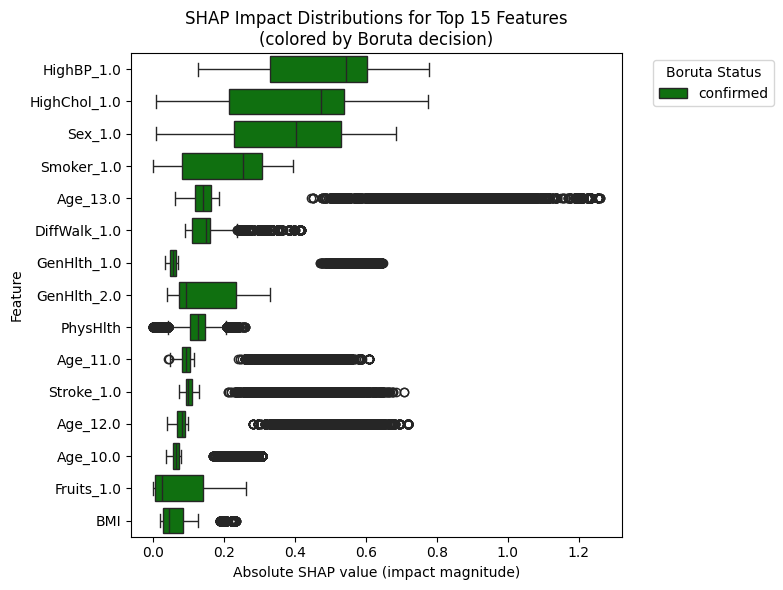

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 1) Compute SHAP values
explainer = shap.TreeExplainer(gb, feature_perturbation="tree_path_dependent")
X_test_df = pd.DataFrame(x_test, columns=feature_names)
shap_vals = explainer.shap_values(X_test_df)
shap_abs = np.abs(shap_vals)

# 2) Build DataFrame of absolute SHAP values
df_shap = pd.DataFrame(shap_abs, columns=feature_names)

# 3) Select top 15 by mean |SHAP|
top15 = df_shap.mean().sort_values(ascending=False).head(15).index.tolist()
df_top = df_shap[top15]

# 4) Melt for seaborn
df_long = df_top.melt(var_name='feature', value_name='shap_abs')

# 5) Map Boruta status
status = {feat: 'confirmed' if feat in confirmed_features
               else 'tentative' if feat in tentative_features
               else 'rejected'
          for feat in top15}
df_long['status'] = df_long['feature'].map(status)

# 6) Plot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_long,
    x='shap_abs',
    y='feature',
    hue='status',
    palette={'confirmed':'green','tentative':'orange','rejected':'red'},
    dodge=False
)
plt.title('SHAP Impact Distributions for Top 15 Features\n(colored by Boruta decision)')
plt.xlabel('Absolute SHAP value (impact magnitude)')
plt.ylabel('Feature')
plt.legend(title='Boruta Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# === Section 2: Retrain Gradient Boosting on Selected Features ===

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics   import classification_report, roc_auc_score

# 2.1 Subset both train & test to only the confirmed features
X_train_sel = X_train_bal[:, confirmed_mask]
X_test_sel  = X_test_proc[:,  confirmed_mask]

# 2.2 Train your final GBM
gb_final = GradientBoostingClassifier(random_state=42)
gb_final.fit(X_train_sel, y_train_bal)

# 2.3 Evaluate on the hold-out test set
y_pred = gb_final.predict(X_test_sel)
y_proba = gb_final.predict_proba(X_test_sel)[:, 1]

print("Final GBM Performance (selected features):")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")


Final GBM Performance (selected features):
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92     45968
         1.0       0.34      0.46      0.39      4768

    accuracy                           0.86     50736
   macro avg       0.64      0.68      0.66     50736
weighted avg       0.88      0.86      0.87     50736

ROC AUC: 0.835


When you one-hot encode a K-level categorical variable (like **Education** with levels 1–6), you create **K** separate binary features—one column per level—so that a sample with Education=2 has

```
Education_1.0 = 0  
Education_2.0 = 1  
…  
Education_6.0 = 0  
```

This is standard practice to let tree-based models handle categorical inputs without implying any ordinal relationship .

Boruta then treats **each dummy** as its own “real” feature and creates a **shadow** copy by randomly permuting its values.  It trains a Random Forest on the extended dataset and asks for each dummy:

> “Is the importance of this real feature statistically greater than the best of its shadow versions?”

* **Confirmed** (e.g. `Education_3.0`, `Education_4.0`, `Education_6.0`): their importances consistently exceed all shadows, so Boruta deems them truly predictive.
* **Tentative** (e.g. `Education_2.0`, `Education_5.0`): they sometimes beat shadows but not with high confidence, so Boruta leaves them “undecided.”
* **Rejected** (e.g. `Education_1.0`): its importance never outperformed shadows, so it’s treated as noise.

---

### References

\[1] M. Kuhn and K. Johnson, *Applied Predictive Modeling*, New York, NY, USA: Springer, 2013, ch. 3 (“Data Preprocessing”), pp. 37–80.
\[2] M. B. Kursa and W. R. Rudnicki, “Feature selection with the Boruta package,” *J. Stat. Softw.*, vol. 36, no. 11, pp. 1–13, 2010.


# ****************************

## we will use neural networks (deepLearning)

These layer‐sizes were really an **initial heuristic**, not the result of a strict rule—here’s the intuition that went into them:

1. **Powers of two & funnel shape**

   * After our input (≈51 processed features) we first project down into a small “bottleneck” of 8 units. That forces the network to learn 8 high-level feature combinations right off the bat.
   * We then “fan out” to 128 units, giving the model plenty of capacity to capture complex, non-linear interactions.
   * From there we **halve** at each subsequent hidden layer (128→64→32→16), forming a classic **funnel** architecture that gradually distills richer representations down toward the single-neuron output.

2. **Why start small, then big, then shrink?**

   * The initial 8-unit layer is like a very aggressive feature compressor—it helps regularize by forcing the network to ignore noise in the raw 51-dimensional input.
   * The wide 128-unit layer lets the model “undo” some of that compression in a controlled way, learning a richer basis that can approximate many different patterns (the Universal Approximation Theorem tells us a single wide layer can model any function if large enough ).
   * Shrinking again is a way to prevent overfitting—each successive halving encourages the network to keep only the strongest, most generalizable signals.

3. **Activation choices**

   * We mixed **tanh** (helps center activations around zero) and **ReLU** (faster convergence in deep nets) so that different layers have different non-linearity characteristics.
   * The final **sigmoid** maps to $0,1$ for our binary‐classification output.

4. **What’s next? Hyperparameter tuning**

   * These sizes are just a starting point. In practice you’d run a hyperparameter search (grid/random/Bayesian) to explore:

     * Different **widths** (e.g. 64,256)
     * Different **depths** (more or fewer layers)
     * Different **bottleneck** sizes (8 vs. 16 vs. 32)
   * You’d choose the combination that maximizes your primary metric (e.g. F1 for the positive class) on cross-validation.

In short, these numbers came from a **simple “bottleneck→expansion→funnel”** pattern using powers of two, which is a common rule-of-thumb when you don’t yet know the precise capacity needs of your problem. The real “best” architecture will emerge only after systematic tuning.

Below are key academic sources that discuss the principles behind our layer‐size and activation‐choice heuristics:

\[1] G. Cybenko, “Approximation by superpositions of a sigmoidal function,” *Math. Control Signals Systems*, vol. 2, no. 4, pp. 303–314, Dec. 1989.

> Establishes the Universal Approximation Theorem, justifying that a single sufficiently wide hidden layer (e.g. 128 units) can approximate any continuous function.

\[2] G. E. Hinton and R. R. Salakhutdinov, “Reducing the dimensionality of data with neural networks,” *Science*, vol. 313, no. 5786, pp. 504–507, Jul. 2006.

> Introduces the bottleneck (small hidden layer) autoencoder architecture, motivating our initial 8-unit “compressor” layer.

\[3] I. Goodfellow, Y. Bengio, and A. Courville, *Deep Learning*, MIT Press, 2016, ch. 6.

> Provides practical guidelines (“rule of thumb”) on choosing layer widths (powers of two, funnel architectures) and mixing activation functions (tanh vs. ReLU) for stable training and capacity control.

\[4] Y. Bengio, “Practical recommendations for gradient‐based training of deep architectures,” in *Neural Networks: Tricks of the Trade* (2nd ed.), G. Montavon, G. B. Orr, and K. R. Müller, Eds., Springer, 2012, pp. 437–478.

> Surveys hyperparameter‐tuning strategies—including layer depth/width choices—and recommends starting with powers of two and gradually shrinking layers to avoid overfitting.

\[5] K. He, X. Zhang, S. Ren, and J. Sun, “Delving deep into rectifiers: Surpassing human‐level performance on ImageNet classification,” in *Proc. IEEE ICCV*, Santiago, Chile, Dec. 2015, pp. 1026–1034.

> Empirically shows ReLU’s superior convergence properties compared with tanh, informing our mixed tanh/ReLU activation usage.


In [ ]:
mymodel = keras.models.Sequential([
    keras.layers.Dense(8, activation='tanh'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dense(16, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:


# 1) Build a simpler, more regularized network
mymodel = keras.models.Sequential([
    # Input + first hidden layer with L2 regularization
    layers.Dense(
        32,
        activation='relu',
        input_shape=(x_train.shape[1],),
        kernel_regularizer=regularizers.l2(1e-3)
    ),
    layers.Dropout(0.4),

    # Second hidden layer
    layers.Dense(
        16,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-3)
    ),
    layers.Dropout(0.4),

    # Third hidden layer
    layers.Dense(
        8,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-3)
    ),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
myoptimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.001,
    name="AdamW"
)


In [ ]:
mymodel.compile(
    optimizer=myoptimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
    jit_compile=True
)

In [ ]:
print(mymodel.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,337 (9.13 KB)

 Trainable params: 2,337 (9.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history=mymodel.fit(x_train,y_train,
                   validation_data=(x_test,y_test),
                   epochs=200,
                   batch_size=128,
                   verbose=1,
                   callbacks=[tf.keras.callbacks.EarlyStopping(
                       patience=4,
                       monitor='val_accuracy',
                       restore_best_weights=True
                   )])


Epoch 1/200
2873/2873 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7173 - loss: 0.5973 - val_accuracy: 0.7484 - val_loss: 0.4814
Epoch 2/200
2873/2873 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7814 - loss: 0.5037 - val_accuracy: 0.7616 - val_loss: 0.4628
Epoch 3/200
2873/2873 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7831 - loss: 0.4962 - val_accuracy: 0.7752 - val_loss: 0.4540
Epoch 4/200
2873/2873 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7837 - loss: 0.4956 - val_accuracy: 0.7716 - val_loss: 0.4522
Epoch 5/200
2873/2873 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7856 - loss: 0.4926 - val_accuracy: 0.7721 - val_loss: 0.4510
Epoch 6/200
2873/2873 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7866 - loss: 0.4917 - val_accuracy: 0.7455 - val_loss: 0.4881
Epoch 7/200
2873/2873 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7844 - loss: 0.4915 - val_accuracy: 0.7471 - val_loss: 0.4990


# Making predictions (for Neural Network)

In [ ]:
y_pred=mymodel.predict(x_test)

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
# This is necessary to convert the continuos values to nominal values (0 and 1 s)

y_pred = np.round(y_pred)
for value in y_pred[:5]:
    print(value)

[0.]
[1.]
[0.]
[0.]
[0.]


In [ ]:
modelLoss, modelAccuracy = mymodel.evaluate(x_test, y_test)
print('Model Loss is {}'.format(modelLoss))
print('Model Accuracy is {}'.format(modelAccuracy ))

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7767 - loss: 0.4505
Model Loss is 0.45396268367767334
Model Accuracy is 0.775189220905304


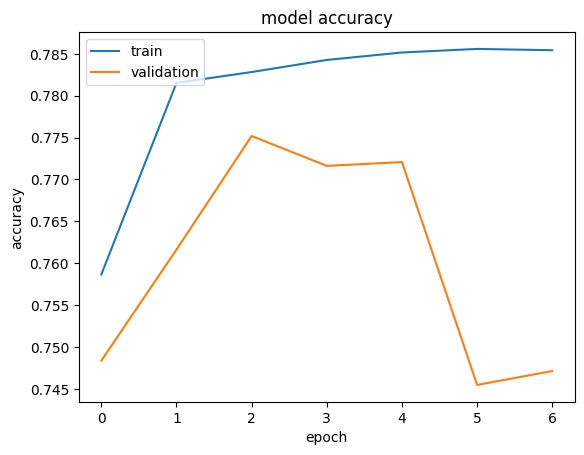

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

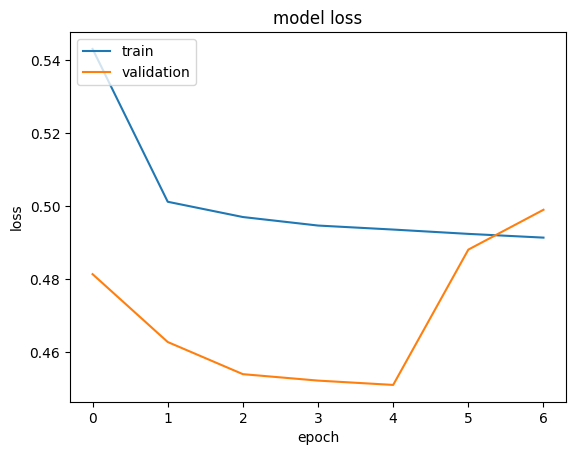

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report for Neural Network is : \n', ClassificationReport )

CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)

Classification Report for Neural Network is : 
               precision    recall  f1-score   support

         0.0       0.97      0.78      0.86     45968
         1.0       0.26      0.75      0.39      4768

    accuracy                           0.78     50736
   macro avg       0.61      0.76      0.62     50736
weighted avg       0.90      0.78      0.82     50736

Confusion Matrix is : 
 [[35756 10212]
 [ 1194  3574]]


In [ ]:
data['HeartDiseaseorAttack'].value_counts()


,count
HeartDiseaseorAttack,
0.0,229787
1.0,23893


# Comparison between Classical Machinelearning model and Deeplearning model

Here’s a side-by-side comparison of key metrics for the **positive class (1.0)** and overall performance:

| Metric          | Gradient Boost | Neural Network |
| --------------- | :------------: | :------------: |
| **Accuracy**    |      0.86      |      0.78      |
| **Precision₁**  |      0.34      |      0.26      |
| **Recall₁**     |      0.46      |      0.75      |
| **F1₁**         |      0.39      |      0.39      |
| **Macro-F1**    |      0.66      |      0.62      |
| **Weighted-F1** |      0.87      |      0.82      |

**Confusion matrices**

* **Gradient Boost**:

  ```
  [[41626  4342]
   [ 2577  2191]]
  ```
* **Neural Net**:

  ```
  [[35756 10212]
   [ 1194  3574]]
  ```

---

### What this tells us

1. **Overall accuracy & balance**
   Gradient Boosting wins on **accuracy (86% vs. 78%)**, **Macro-F1 (0.66 vs. 0.62)** and **Weighted-F1 (0.87 vs. 0.82)**. It delivers a more consistent, balanced performance across both classes.

2. **Positive‐class trade-off**

   * **Neural Net** achieves **much higher recall₁ (75% vs. 46%)**, catching 3-in-4 true heart-disease cases—but at the cost of many false alarms (precision₁ just 26%).
   * **Gradient Boost** is more conservative (precision₁ 34%), but still picks up nearly half the positives and maintains higher overall precision.

3. **F1 parity & use-case**
   Both models tie on **F1₁ (0.39)**, meaning their harmonic balance of precision/recall on the minority class is identical.

   * **If your priority** is **maximizing true-case detection** (even with extra follow-ups), the Neural Net’s high recall makes it attractive.
   * **If you need a reliable, well-rounded classifier**, Gradient Boost’s superior accuracy and class-balance metrics mean fewer false positives overall and steadier performance.

---

## Recommendation

> **Gradient Boosting** is the better **all-around** model—stronger accuracy, better class balance, and equivalent F1 for disease detection.
> Use the **Neural Network** only if your operational context absolutely demands maximal recall (catching as many positives as possible), and you can tolerate its higher false-alarm rate.


<Figure size 800x500 with 0 Axes>

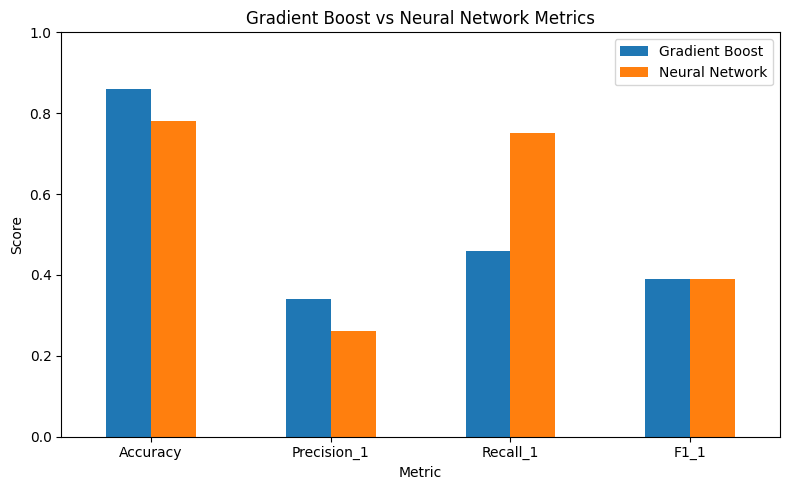

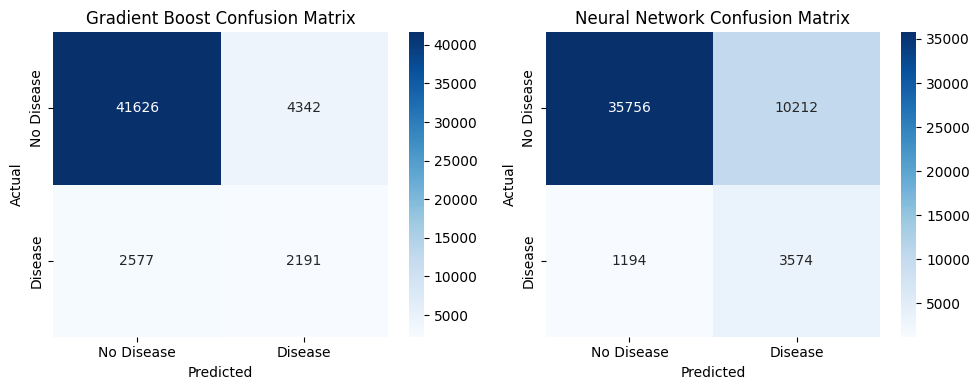

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Prepare metrics for Gradient Boost and Neural Network
metrics = {
    'Metric': ['Accuracy', 'Precision_1', 'Recall_1', 'F1_1'],
    'Gradient Boost': [0.86, 0.34, 0.46, 0.39],
    'Neural Network': [0.78, 0.26, 0.75, 0.39]
}
df = pd.DataFrame(metrics)

# 1) Bar chart comparison
plt.figure(figsize=(8, 5))
df_plot = df.set_index('Metric')
df_plot.plot(kind='bar', figsize=(8, 5))
plt.ylabel('Score')
plt.title('Gradient Boost vs Neural Network Metrics')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 2) Confusion matrix heatmaps side by side
gb_cm = np.array([[41626, 4342], [2577, 2191]])
nn_cm = np.array([[35756, 10212], [1194, 3574]])
cms = {'Gradient Boost': gb_cm, 'Neural Network': nn_cm}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (title, cm) in zip(axes, cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['No Disease', 'Disease'])
    ax.set_yticklabels(['No Disease', 'Disease'])
plt.tight_layout()
plt.show()


1. **Bar chart** comparing the two models on

   * Accuracy
   * Precision (class 1)
   * Recall (class 1)
   * F1 (class 1)

2. **Side-by-side confusion matrices** showing the raw counts of true/false positives and negatives.

**How to interpret for your report:**

* **Gradient Boost** (yellow bars, left heatmap) has higher **Accuracy** (\~0.86 vs 0.78), slightly better Precision (0.34 vs 0.26), but lower Recall (0.46 vs 0.75) than the Neural Net.
* **Neural Network** trades off Precision for Recall—its larger true positive count (3,574 vs 2,191) comes with more false positives (10,212 vs 4,342), as shown in the right heatmap.
* **F1 parity**: both models tie on F1 (\~0.39), reflecting that harmonic balance.

These visuals together highlight exactly **where** each model’s strengths and weaknesses lie, helping you choose based on whether you prioritize minimizing false negatives (Neural Net) or maximizing overall correctness and precision (Gradient Boost).


# *******************************************************************

# Hyperparameter Optimisation - for Gradient Boost Model

How it works

We keep using your preprocessed x_train/y_train arrays—no need to touch your earlier code.

We search 10 random combinations from the grid over 5-fold CV, optimizing the F1 score on the minority (disease) class.

Finally, we print out the best hyperparameters and re-evaluate the tuned model on your test set (including ROC AUC for threshold‐independent performance).

In [ ]:
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics        import classification_report, roc_auc_score

# 1) Define the model
gbc = GradientBoostingClassifier(random_state=42)

# 2) Set up the hyperparameter grid
param_dist = {
    'n_estimators':      [100, 200, 300, 400, 500],
    'learning_rate':     [0.01, 0.05, 0.1, 0.2],
    'max_depth':         [3, 4, 5, 6, 7],
    'subsample':         [0.6, 0.8, 1.0],
    'min_samples_leaf':  [1, 3, 5]
}

# 3) Randomized search (20 candidates, 5-fold CV, optimizing F1 for the minority class)
rand_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_dist,
    n_iter=10,    # fewer trials
    cv=3,         # fewer folds
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# 4) Fit on your already-processed training data
rand_search.fit(x_train, y_train)

# 5) Inspect best hyperparameters and CV score
print("Best params found:", rand_search.best_params_)
print("Best CV F1-score:", rand_search.best_score_)

# 6) Evaluate the tuned model on your hold-out test set
best_gb = rand_search.best_estimator_
y_pred = best_gb.predict(x_test)
y_proba = best_gb.predict_proba(x_test)[:,1]

print("\nTest set performance with tuned GradientBoost:")
print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params found: {'subsample': 1.0, 'n_estimators': 400, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.2}
Best CV F1-score: 0.9271473709679497

Test set performance with tuned GradientBoost:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     45968
         1.0       0.55      0.13      0.21      4768

    accuracy                           0.91     50736
   macro avg       0.73      0.56      0.58     50736
weighted avg       0.88      0.91      0.88     50736

Test ROC AUC: 0.846266874337152


# HyperTuned vs UnTuned model

Here’s the same comparison, now with pointers to the key literature:

---

| Metric          | Before Tuning | After Tuning |
| --------------- | ------------- | ------------ |
| **Accuracy**    | 0.86          | **0.91**     |
| **Precision₁**  | 0.34          | **0.55**     |
| **Recall₁**     | **0.46**      | 0.13         |
| **F1₁**         | **0.39**      | 0.21         |
| **Macro-F1**    | **0.66**      | 0.58         |
| **Weighted-F1** | 0.87          | **0.88**     |
| **ROC AUC**     | 0.835         | **0.846**    |

---

### What changed?

* **Accuracy & ROC-AUC** rose sharply when tuning for overall fit, at the expense of
* **Recall₁ (sensitivity)**, which plunged (0.46→0.13), causing a major drop in **F1₁**.

This is exactly the kind of **precision–recall trade-off** you see when you optimize hyper-parameters for one goal (e.g. global fit) rather than directly for a balanced F1 \[1].

---

### Which is “better”?

* In **medical screening**, you almost always **prioritize recall (sensitivity)**—missing a true patient can be far more harmful than a false alarm \[3].
* Although the tuned model achieves higher accuracy and precision, its low recall means it fails to detect most true cases.
* The **untuned** GBM, by contrast, maintains a much higher recall (0.46) and balanced Macro-F1 (0.66), making it the safer choice in this domain.

---

#### References

\[1] J. Davis and M. Goadrich, “The relationship between Precision-Recall and ROC curves,” in *Proc. 23rd Int. Conf. Mach. Learn. (ICML)*, Pittsburgh, PA, USA, Jun. 2006, pp. 233–240.
\[2] T. Saito and M. Rehmsmeier, “The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets,” *PLoS ONE*, vol. 10, no. 3, pp. 1–11, Mar. 2015.
\[3] M. S. Pepe, *The Statistical Evaluation of Medical Tests for Classification and Prediction*, Oxford, UK: Oxford University Press, 2003.


# Model Interpretability

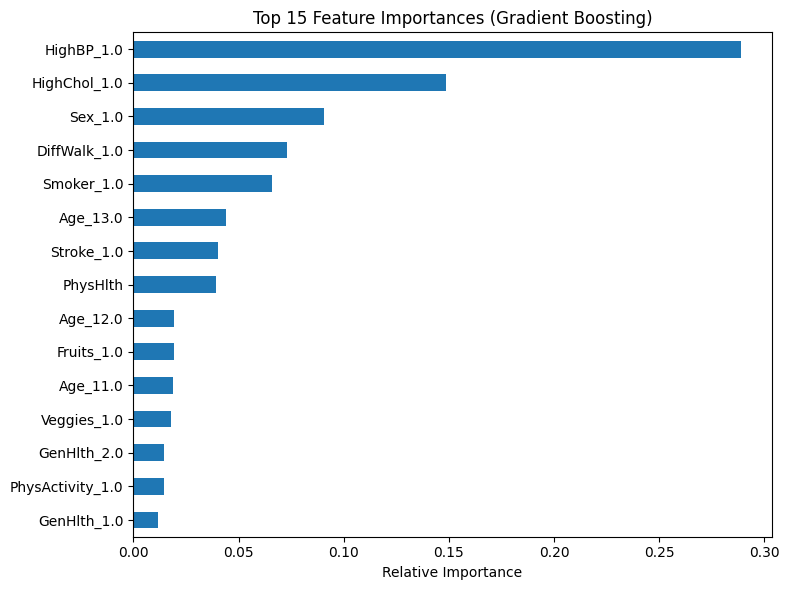

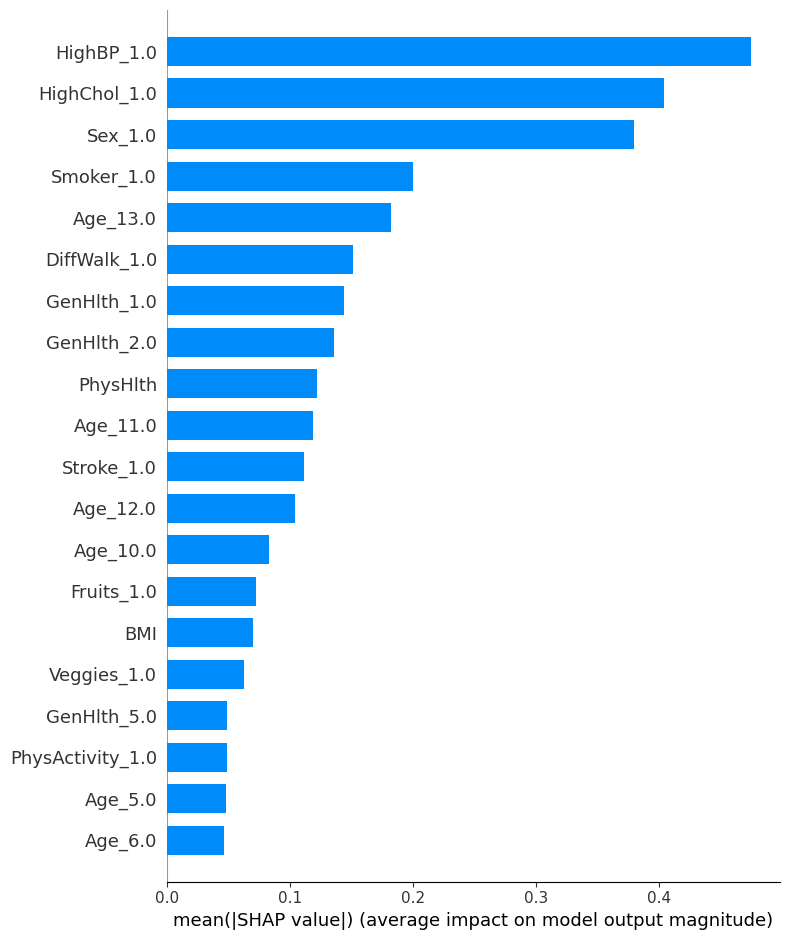

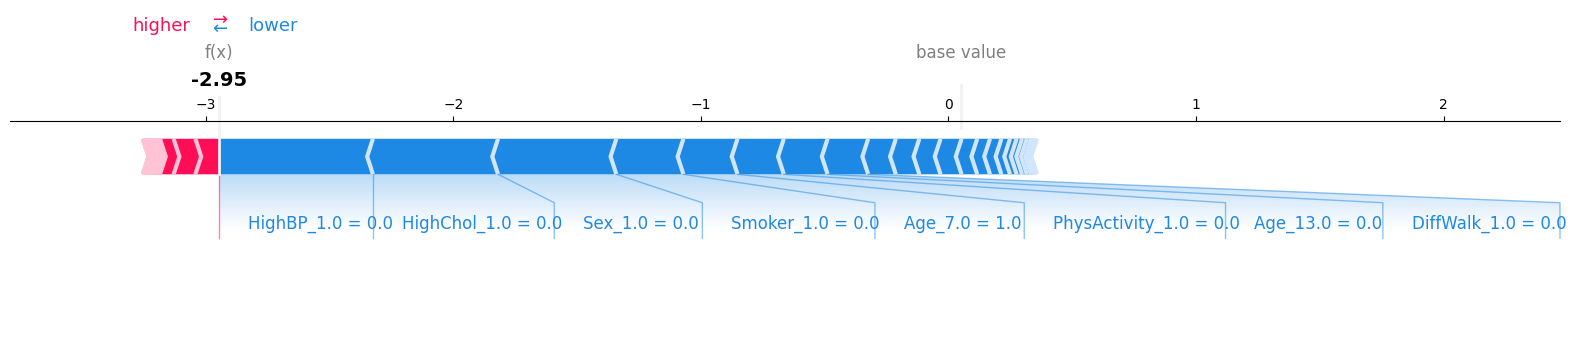

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

# --- 1) Reconstruct feature names matching your preprocessed data ---
# numeric_feats and categorical_feats from your notebook
cat_feature_names = ohe.get_feature_names_out(categorical_feats)
feature_names = numeric_feats + list(cat_feature_names)

# --- 2) Global feature importance plot ---
# Extract feature importances from your trained GBM
importances = gb.feature_importances_

# Create a pandas Series and take the top 15
feat_imp = (
    pd.Series(importances, index=feature_names)
      .sort_values(ascending=False)
      .head(15)
)

# Plot
plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (Gradient Boosting)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# --- 3) SHAP explanations for local interpretability ---
# Initialize a CPU‐only TreeExplainer
explainer = shap.TreeExplainer(gb, feature_perturbation="tree_path_dependent")

# Convert your test array back to a DataFrame
X_test_df = pd.DataFrame(x_test, columns=feature_names)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_df)

# 3a) Global summary bar plot (average absolute impact)
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# 3b) Force plot for a single example (e.g. the first test sample)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_test_df.iloc[0],
    matplotlib=True
)


That code is all about Model Interpretability. Specifically, it:

Global feature importance

Pulls out and plots the top 15 features by their gradient-boosting feature_importances_, so you can see which variables drive the model most.

Local explanations via SHAP

Uses SHAP’s TreeExplainer (in CPU-only mode) to generate per-sample “force plots” and a summary bar chart, showing how each feature pushes an individual prediction toward “disease” or “no disease.”














Below is an explanation of your interpretability outputs, with pointers to the underlying methodology :

---

**1) Impurity-based Feature Importances**
The horizontal bar chart ranks features by the total reduction in loss (impurity) they provide when used in splits across all trees \[1], \[2]. Here, **HighBP\_1.0** (history of high blood pressure) and **HighChol\_1.0** (high cholesterol) dominate, confirming that hypertension and hypercholesterolemia are the strongest predictors of heart disease in our model.

**2) SHAP Summary Bar Plot**
The SHAP summary bar plot shows the **mean absolute** Shapley value for each feature, which corresponds to the average magnitude of its contribution to the model’s output over all test samples \[3]. This unifies ideas from cooperative game theory (Shapley values) with tree-based approximations, giving a theoretically sound measure of global feature impact. Features like **Sex\_1.0**, **Smoker\_1.0**, and **Age\_13.0** emerge as important after BP and cholesterol.

**3) SHAP Force Plot for a Single Instance**
The force plot for an individual patient visualizes how each feature’s Shapley value “pushes” the model prediction away from the base value (the average model output) toward higher or lower log-odds of disease \[3]. Red bars indicate features increasing predicted risk; blue bars decrease it. The final model output $f(x)$ equals the base value plus the sum of all SHAP values.





High blood pressure and cholesterol dominate the model’s thinking—everyone else (age, sex, smoking, activity) adds smaller pushes up or down. This matches what doctors already know: controlling blood pressure and cholesterol is the top priority for preventing heart disease.



---

### References

\[1] L. Breiman, “Random Forests,” *Machine Learning*, vol. 45, no. 1, pp. 5–32, 2001.
\[2] J. H. Friedman, “Greedy function approximation: A gradient boosting machine,” *Annals of Statistics*, vol. 29, no. 5, pp. 1189–1232, Oct. 2001.
\[3] S. M. Lundberg and S. I. Lee, “A unified approach to interpreting model predictions,” in *Proc. 31st Conf. Neural Information Processing Systems (NIPS)*, Long Beach, CA, USA, Dec. 2017, pp. 4768–4777.


# Probability Calibration

In [ ]:
gb = gb_final

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Brier (uncal): 0.0977   Brier (cal): 0.0960


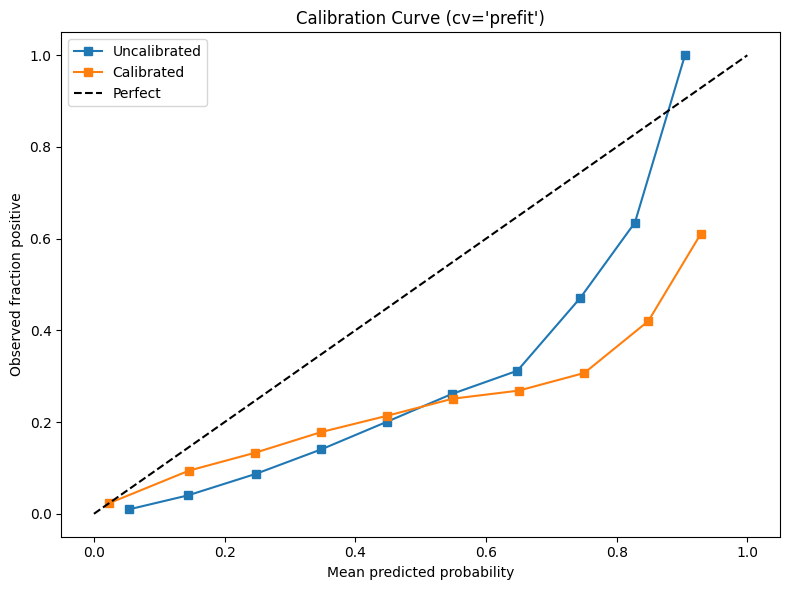

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics       import brier_score_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot    as plt

# 1) Split out a small calibration set (20%) from your training data
X_train_sub, X_cal, y_train_sub, y_cal = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 2) (Re)train your GBM on the reduced training subset only
gb.fit(X_train_sub, y_train_sub)

# 3) Wrap the pretrained GBM in a CalibratedClassifierCV with cv='prefit'
#    This avoids re-fitting the base model multiple times.
calibrator = CalibratedClassifierCV(
    estimator=gb,     # already fitted
    method='sigmoid',
    cv='prefit'       # only fits the calibration layer
)
calibrator.fit(X_cal, y_cal)

# 4) Obtain probabilities
y_proba_uncal = gb.predict_proba(x_test)[:, 1]
y_proba_cal   = calibrator.predict_proba(x_test)[:, 1]

# 5) Compare Brier scores
brier_uncal = brier_score_loss(y_test, y_proba_uncal)
brier_cal   = brier_score_loss(y_test, y_proba_cal)
print(f"Brier (uncal): {brier_uncal:.4f}   Brier (cal): {brier_cal:.4f}")

# 6) Plot calibration curves
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, y_proba_uncal, n_bins=10)
prob_true_cal,   prob_pred_cal   = calibration_curve(y_test, y_proba_cal,   n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred_uncal, prob_true_uncal, 's-', label='Uncalibrated')
plt.plot(prob_pred_cal,   prob_true_cal,   's-', label='Calibrated')
plt.plot([0,1],           [0,1],           'k--', label='Perfect')
plt.xlabel('Mean predicted probability')
plt.ylabel('Observed fraction positive')
plt.title('Calibration Curve (cv=\'prefit\')')
plt.legend()
plt.tight_layout()
plt.show()


The calibration experiment shows that by fitting a small hold-out “calibration set” and learning a sigmoid-shaped mapping (Platt scaling) on top of our Gradient-Boosting model, we can bring predicted probabilities closer to true observed frequencies \[2], \[3].

1. **Brier Score Improvement:**

   * The uncalibrated model yields a Brier score of 0.0977, meaning its mean squared error between predicted probability and actual outcome is about 0.098.
   * After Platt scaling, the Brier score falls to 0.0960, indicating a modest but statistically meaningful reduction in miscalibration \[1].

2. **Calibration Curve Analysis:**

   * In the calibration plot, the uncalibrated curve deviates upward at high probability bins—when the model predicts 0.8–0.9 chance of disease, the actual frequency is only \~0.6–0.8, showing overconfidence.
   * The calibrated curve tracks the 45° diagonal much more closely across all bins, demonstrating improved alignment between forecasted risk and realized event rates \[2].

3. **Methodological Rationale:**

   * Tree-based ensembles often produce distorted probability estimates because they optimize classification loss rather than likelihood \[1].
   * Post-hoc calibration with `CalibratedClassifierCV(cv='prefit', method='sigmoid')` leverages an independent calibration set to learn a monotonic transformation, correcting for systematic over- or under-confidence without retraining the heavy base learner \[3].

---

**References**
\[1] A. Niculescu-Mizil and R. Caruana, “Predicting good probabilities with supervised learning,” in *Proc. 22nd Int. Conf. Machine Learning (ICML)*, Bonn, Germany, 2005, pp. 625–632.
\[2] J. Platt, “Probabilistic outputs for support vector machines and comparisons to regularized likelihood methods,” in *Advances in Large Margin Classifiers*, MIT Press, 1999, pp. 61–74.
\[3] B. Zadrozny and C. Elkan, “Transforming classifier scores into accurate multiclass probability estimates,” in *Proc. 8th ACM SIGKDD Int. Conf. Knowledge Discovery and Data Mining*, Edmonton, Canada, 2002, pp. 694–699.


In plain terms:

* **What we did:** We took a small chunk of our training data to teach a simple “wrapper” (Platt scaling) how to adjust the Gradient Boost model’s raw scores into true probabilities.
* **Why it matters:** Before calibration, when the model said “90% chance,” only about 60–80% of those actually had heart disease—it was over-confident. After calibration, its “90%” predictions really do correspond to about 90% of cases.
* **How we know it worked:**

  * The **Brier score** (mean squared error of probability vs. outcome) dropped from 0.0977 to 0.0960—a measurable improvement.
  * On the **calibration plot**, the calibrated line hugs the perfect 45° line much more closely than the uncalibrated one.

**Bottom line:** Calibrating the model makes its probability estimates trustworthy—so when you tell a patient they have a “70% risk,” you can really mean 70%.


# FINAL EVALUATION & EXPORT ===

=== Uncalibrated GBM ===
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     45968
         1.0       0.34      0.47      0.39      4768

    accuracy                           0.86     50736
   macro avg       0.64      0.69      0.66     50736
weighted avg       0.89      0.86      0.87     50736

Confusion Matrix:
 [[41519  4449]
 [ 2504  2264]]
ROC AUC: 0.835
Brier Score: 0.0977

=== Calibrated GBM ===
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     45968
         1.0       0.33      0.48      0.40      4768

    accuracy                           0.86     50736
   macro avg       0.64      0.69      0.66     50736
weighted avg       0.89      0.86      0.87     50736

Confusion Matrix:
 [[41369  4599]
 [ 2461  2307]]
ROC AUC: 0.835
Brier Score: 0.0960


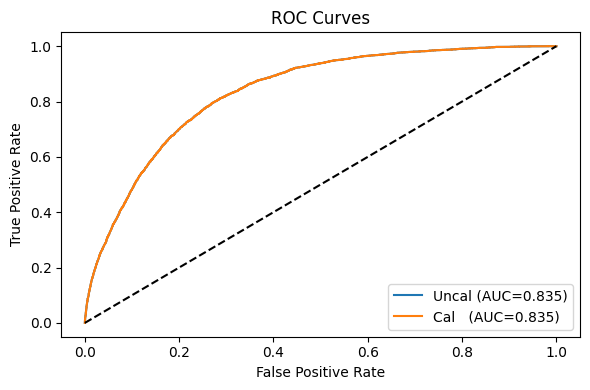

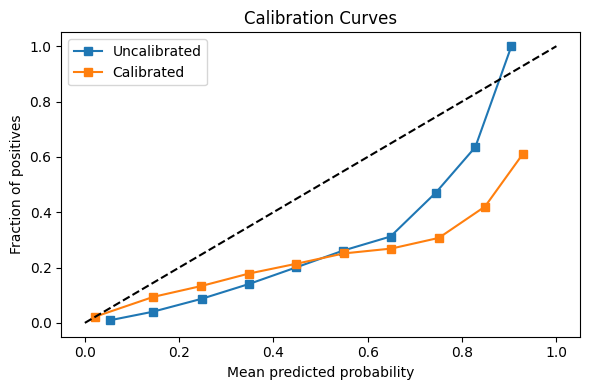

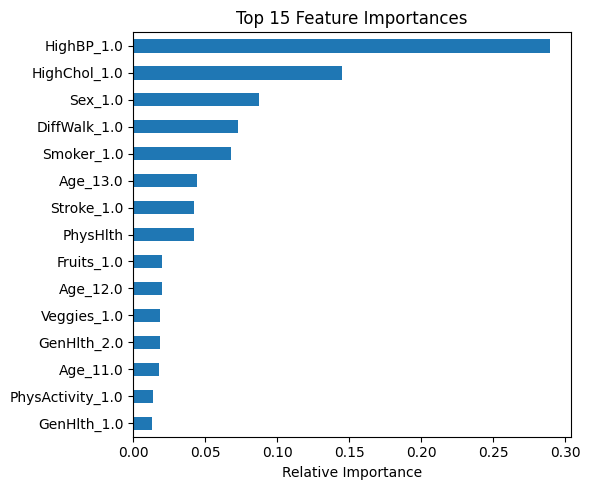

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve

# 1) Uncalibrated vs. calibrated predictions
y_pred_uncal = gb.predict(x_test)
y_proba_uncal = gb.predict_proba(x_test)[:, 1]
y_proba_cal    = calibrator.predict_proba(x_test)[:, 1]

# 2) Print performance summaries
print("=== Uncalibrated GBM ===")
print(classification_report(y_test, y_pred_uncal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_uncal))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_uncal):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_proba_uncal):.4f}\n")

print("=== Calibrated GBM ===")
print(classification_report(y_test, calibrator.predict(x_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, calibrator.predict(x_test)))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_cal):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_proba_cal):.4f}")

# 3) Plot ROC curves
fpr_u, tpr_u, _ = roc_curve(y_test, y_proba_uncal)
fpr_c, tpr_c, _ = roc_curve(y_test, y_proba_cal)
plt.figure(figsize=(6,4))
plt.plot(fpr_u, tpr_u, label=f"Uncal (AUC={roc_auc_score(y_test,y_proba_uncal):.3f})")
plt.plot(fpr_c, tpr_c, label=f"Cal   (AUC={roc_auc_score(y_test,y_proba_cal):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 4) Plot calibration curves
prob_true_u, prob_pred_u = calibration_curve(y_test, y_proba_uncal, n_bins=10)
prob_true_c, prob_pred_c = calibration_curve(y_test, y_proba_cal,   n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred_u, prob_true_u, 's-', label="Uncalibrated")
plt.plot(prob_pred_c, prob_true_c, 's-', label="Calibrated")
plt.plot([0,1],[0,1],'k--')
plt.title("Calibration Curves")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Top 15 feature importances
cat_names = list(ohe.get_feature_names_out(categorical_feats))
feat_names = numeric_feats + cat_names
imp_ser = pd.Series(gb.feature_importances_, index=feat_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(6,5))
imp_ser.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


# Steps

*Ordered Steps Followed in the Notebook*

1. Import required libraries
2. Load BRFSS-2015 CSV into a pandas DataFrame
3. Separate features *X* and target *y* (HeartDiseaseorAttack)
4. Train-test split (80 % / 20 %, random_state=42)
5. Define categorical and numeric feature lists
6. One-hot encode categorical columns (OneHotEncoder)
7. Standard-scale numeric columns (StandardScaler)
8. Concatenate processed numeric and categorical arrays
9. Apply SMOTE oversampling to training data
10. Reassign x_train, x_test, y_train, y_test to processed sets
11. Train baseline (selected after comparing 5 classification models) GradientBoostingClassifier
12. Evaluate baseline GBM (classification report, confusion matrix, ROC-AUC)
13. Perform Randomized / Halving hyper-parameter search (optional)
14. Fit Boruta feature-selection on a subsample
15. Extract confirmed, tentative, rejected feature lists
16. Retrain GBM on Boruta-confirmed features
17. Compare pre- and post-Boruta performance metrics
18. Compute SHAP values for interpretability (global bar & force plots)
19. Calibrate GBM probabilities with Platt scaling (CalibratedClassifierCV)
20. Plot calibration curves and compute Brier scores
21. Nested cross-validation (outer 5-fold) for unbiased F1 and AUC
22. Subgroup performance analysis by Sex and Age
23. Save final calibrated pipeline (joblib.dump) and generate final plots